# Learn To Synchronize Videos

## Model declaration

In [1]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sync_net
import trainer
import metrics
import data_loader
reload(sync_net)
reload(trainer)
reload(metrics)
reload(data_loader)
from sync_net import reset_first_layer, replace_last_layer, add_sigmoid_activation, stop_running_var, freeze_model, TripletNet, MultiSiameseNet, TripletLoss, CosineSimilarityTripletLoss, LosslessTripletLoss, MultiSiameseCosineSimilarityLoss, SoftMultiSiameseCosineSimilarityLoss
from trainer import fit
from metrics import EmbeddingL2DistanceMetric, EmbeddingCosineSimilarityMetric, EmbeddingCosineSimilarityAndDistanceLossMetric
from data_loader import get_datasets, get_test_set, get_multisiamese_datasets, get_soft_multisiamese_datasets
# import wandb
# wandb.init(project="learn-to-synchronize-videos")
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
embedding_net = models.mobilenet_v2(pretrained=True)  # models.resnet50(pretrained=True)
# reset_first_layer(embedding_net)
# freeze_model(embedding_net)
replace_last_layer(embedding_net, 32)  # , dropout=0.2931518740481574)
embedding_net.apply(stop_running_var)
# embedding_net = add_sigmoid_activation(embedding_net)  # Use only with LosslessTripletLoss
# model = TripletNet(embedding_net)
model = MultiSiameseNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# print([x.requires_grad for x in model.parameters()])
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# loss_fn = TripletLoss(margin=0.5)
# loss_fn = CosineSimilarityTripletLoss(margin=0.5)
# loss_fn = LosslessTripletLoss()
# loss_fn = MultiSiameseCosineSimilarityLoss()
loss_fn = SoftMultiSiameseCosineSimilarityLoss()
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2, eta_min=5e-6, last_epoch=-1)
scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\test"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
# wandb.config.lr = lr
# wandb.config.optimizer = type(optimizer)
# wandb.config.loss_fn = type(loss_fn)
print("loaded")

loaded


## Load dataset

### Angio sequence triplets

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

### Angio sequence multi siamese

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_multisiamese_datasets(training_path, validation_path, 1000, 64)

### Angio sequence soft multi siamese

In [2]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_paths = [
    r'C:\Users\root\Data\Angiographie\ABL-5',
    r'C:\Users\root\Data\Angiographie\G1',
    r'C:\Users\root\Data\Angiographie\G18'
]
max_cycles_for_pairs = 2.5
sequence = 3
batch_size = 32
inter_video_pairs = False
use_data_augmentation = False
training_set, validation_set = get_soft_multisiamese_datasets(training_path, validation_paths, max_cycles_for_pairs, sequence, 1000, batch_size, inter_video_pairs, use_data_augmentation)

105 valid frames [32, 136] @22.0 and contracted at index 43.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames [50, 159] @22.5 and contracted at index 60.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
109 valid frames [44, 152] @22.0 and contracted at index 46.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
76 valid frames [56, 131] @20.0 and contracted at index 34.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames [53, 131] @20.0 and contracted at index 36.0, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames [35, 155] @22.0 and contracted at index 68.0, in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames [35, 147] @23.0 and contracted at index 47.0, in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
46 valid frames [23, 68] @11.5 and contracted at index 17.0, in C:\Users\root\Data\Angiographie\AC-1\export\LCA_40RA015CAU
49 valid frames [26, 74] @11.5 and cont

43 valid frames [26, 68] @9.0 and contracted at index 18.0, in C:\Users\root\Data\Angiographie\KR-11\export\LCA_30RAO
51 valid frames [29, 79] @9.5 and contracted at index 21.0, in C:\Users\root\Data\Angiographie\KR-11\export\LCA_AP
46 valid frames [32, 77] @9.5 and contracted at index 26.5, in C:\Users\root\Data\Angiographie\KR-11\export\LCA_LAT
68 valid frames [14, 81] @9.0 and contracted at index 32.5, in C:\Users\root\Data\Angiographie\KR-11\export\RCA_AP
77 valid frames [11, 87] @9.0 and contracted at index 35.0, in C:\Users\root\Data\Angiographie\KR-11\export\RCA_LAT
53 valid frames [25, 77] @11.0 and contracted at index 28.0, in C:\Users\root\Data\Angiographie\MAL-8\export\LCA_AP
52 valid frames [25, 76] @11.0 and contracted at index 28.0, in C:\Users\root\Data\Angiographie\MAL-8\export\LCA_LAT
43 valid frames [19, 61] @11.5 and contracted at index 25.0, in C:\Users\root\Data\Angiographie\MAL-8\export\RCA_AP
40 valid frames [19, 58] @11.5 and contracted at index 24.5, in C:\User

72 valid frames [27, 98] @19.0 and contracted at index 27.0, in C:\Users\root\Data\Angiographie\P25\export\LCA_31_-25
46 valid frames [10, 55] @21.0 and contracted at index 29.0, in C:\Users\root\Data\Angiographie\P25\export\LCA_31_25_1
103 valid frames [46, 148] @18.0 and contracted at index 52.0, in C:\Users\root\Data\Angiographie\P25\export\RCA_0_0_1
144 valid frames [59, 202] @19.0 and contracted at index 63.0, in C:\Users\root\Data\Angiographie\P25\export\RCA_0_0_2
71 valid frames [75, 145] @17.0 and contracted at index 30.0, in C:\Users\root\Data\Angiographie\P25\export\RCA_0_0_3
110 valid frames [42, 151] @17.5 and contracted at index 57.0, in C:\Users\root\Data\Angiographie\P25\export\RCA_90_0_1
151 valid frames [59, 209] @19.5 and contracted at index 83.0, in C:\Users\root\Data\Angiographie\P25\export\RCA_90_0_2
72 valid frames [73, 144] @17.0 and contracted at index 33.0, in C:\Users\root\Data\Angiographie\P25\export\RCA_90_0_3
29 valid frames [15, 43] @9.0 and contracted at 

Computing pair similarities (7/209)
Computing pair similarities (8/209)
Computing pair similarities (9/209)
Computing pair similarities (10/209)
Computing pair similarities (11/209)
Computing pair similarities (12/209)
Computing pair similarities (13/209)
Computing pair similarities (14/209)
Computing pair similarities (15/209)
Computing pair similarities (16/209)
Computing pair similarities (17/209)
Computing pair similarities (18/209)
Computing pair similarities (19/209)
Computing pair similarities (20/209)
Computing pair similarities (21/209)
Computing pair similarities (22/209)
Computing pair similarities (23/209)
Computing pair similarities (24/209)
Computing pair similarities (25/209)
Computing pair similarities (26/209)
Computing pair similarities (27/209)
Computing pair similarities (28/209)
Computing pair similarities (29/209)
Computing pair similarities (30/209)
Computing pair similarities (31/209)
Computing pair similarities (32/209)
Computing pair similarities (33/209)
Comp

40 valid frames [43, 82] @18.5 and contracted at index 26.0, in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
40 valid frames [43, 82] @18.5 and contracted at index 26.0, in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
39 valid frames [29, 67] @8.0 and contracted at index 18.0, in C:\Users\root\Data\Angiographie\G1\export\15
42 valid frames [24, 65] @8.0 and contracted at index 22.5, in C:\Users\root\Data\Angiographie\G1\export\16
39 valid frames [24, 62] @9.0 and contracted at index 19.0, in C:\Users\root\Data\Angiographie\G1\export\17
27 valid frames [21, 47] @8.5 and contracted at index 13.5, in C:\Users\root\Data\Angiographie\G1\export\18
38 valid frames [24, 61] @8.5 and contracted at index 21.0, in C:\Users\root\Data\Angiographie\G1\export\19
42 valid frames [27, 68] @8.5 and contracted at index 20.0, in C:\Users\root\Data\Angiographie\G1\export\20
47 valid frames [25, 71] @8.5 and contracted at index 19.0, in C:\Users\root\Data\Angiographie\G1\export\21
45 valid fr

### Load MNIST dataset instead

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(r"C:\Users\root\Data\MNIST", train=True, download=True, transform=transformations)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.mnist_dataset)
    
    
triplet_mnist = TripletMNIST(mnist_trainset)
train_loader = DataLoader(triplet_mnist, batch_size=20, shuffle=True, num_workers=0)
# for batch_index, triplet in enumerate(train_loader):
#     for i, image in enumerate(triplet):
#         print(f"batch {batch_index}, i {i}, triplet {image.numpy().shape}")
#         plt.subplot(1, 3, i+1)
#         plt.imshow(image.view(224, 224).numpy())
#         plt.title("Anchor" if i == 0 else "Positive" if i == 1 else "Negative")
#     plt.show()
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, None, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics)

## Load training state

In [ ]:
# load_state_path = save_path + r"\training_state_0.pth"
load_state_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\freeze_after_3_epochs\training_state_2.pth"
print(load_state_path)
state = torch.load(load_state_path)
print(state.keys())

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

## Train

In [4]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

### Angio sequence triplets

In [ ]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

### Angio sequence multisiamese

In [6]:
train_loader = DataLoader(training_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=0)
metrics = []  # [EmbeddingCosineSimilarityAndDistanceLossMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

Starting Epoch 0
Will sample from train_loader
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([30, 128])
Similarity matrix: torch.Size([1, 30, 30])
Embeddings: torch.Size([26, 128])
Similarity matrix: torch.Size([1, 26, 26])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 128])
Similarity matrix: torch.Size([1, 32, 32])
Embeddings: torch.Size([32, 1

KeyboardInterrupt: 

## Test trained model

### Load model

In [2]:
test_folder_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\hyperparameter_search_sept_26\2"
# test_folder_path = save_path
# Find latest model weights in folder
latest_epoch = -1
for file in os.listdir(test_folder_path):
    if ".pth" in file:
        epoch = int(file.split("_")[-1].split(".")[0])
        if epoch > latest_epoch:
            latest_epoch = epoch
load_state_path = test_folder_path + fr"\training_state_{latest_epoch}.pth"

print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\hyperparameter_search_sept_26\2\training_state_5.pth


DataParallel(
  (module): MultiSiameseNet(
    (embedding_net): MobileNetV2(
      (features): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): ReLU6(inplace)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
              (2): ReLU6(inplace)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
     

### Load test set

In [3]:
reload(data_loader)
from data_loader import get_test_set

# test_paths = [r'C:\Users\root\Data\Angiographie']
test_paths = [
    r'C:\Users\root\Data\Angiographie\ABL-5',
    # r'C:\Users\root\Data\Angiographie\G1',
    # r'C:\Users\root\Data\Angiographie\G18'
]
test_set = get_test_set(test_paths)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)

76 valid frames [33, 108] @18.5 and contracted at index 42.0, in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
82 valid frames [41, 122] @18.0 and contracted at index 39.0, in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
89 valid frames [37, 125] @17.0 and contracted at index 43.0, in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
93 valid frames [38, 130] @17.5 and contracted at index 42.0, in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
40 valid frames [43, 82] @18.5 and contracted at index 26.0, in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
40 valid frames [43, 82] @18.5 and contracted at index 26.0, in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
Computing pair similarities (1/6)
Computing pair similarities (2/6)
Computing pair similarities (3/6)
Computing pair similarities (4/6)
Computing pair similarities (5/6)
Computing pair similarities (6/6)


### Compute distance and similarity matrices for each video

Batch 1/6 (ABL-5 LCA_30LAO25CRA) with 74 sequences


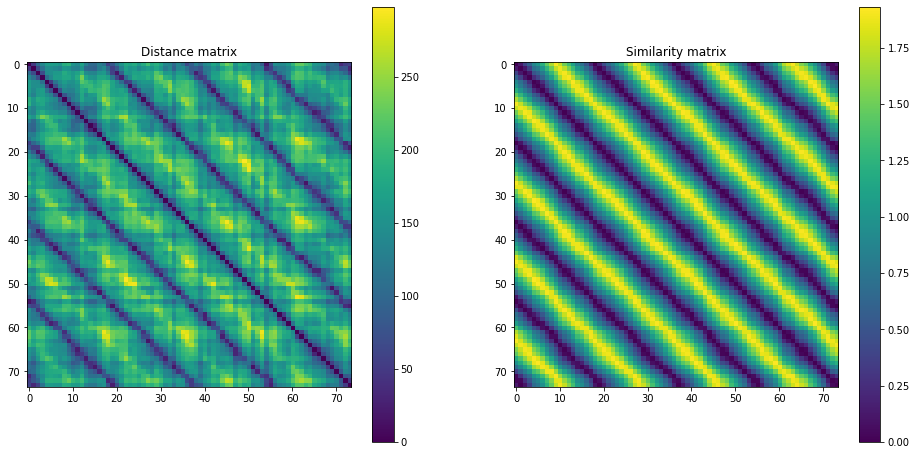

Batch 2/6 (ABL-5 LCA_30RAO) with 80 sequences


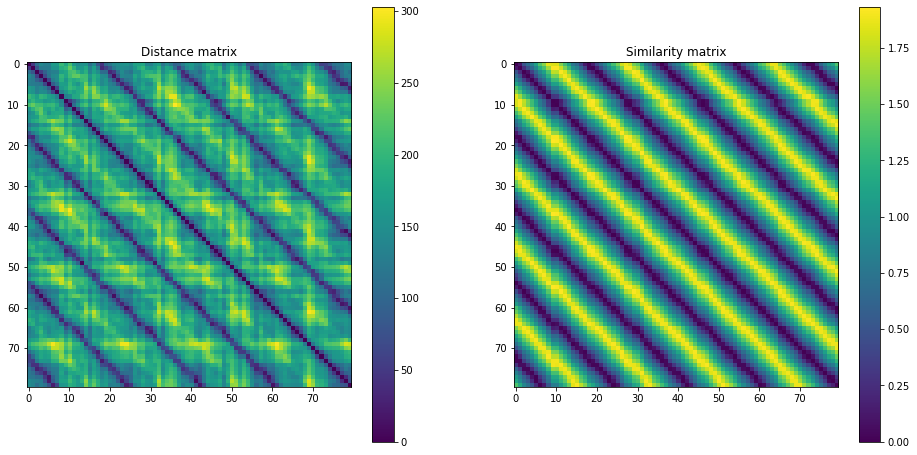

Batch 3/6 (ABL-5 LCA_AP) with 87 sequences


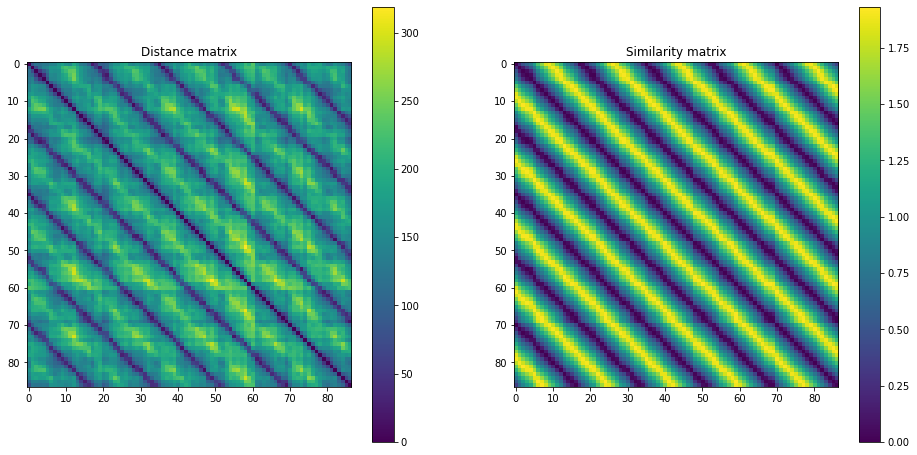

Batch 4/6 (ABL-5 LCA_LAT) with 91 sequences


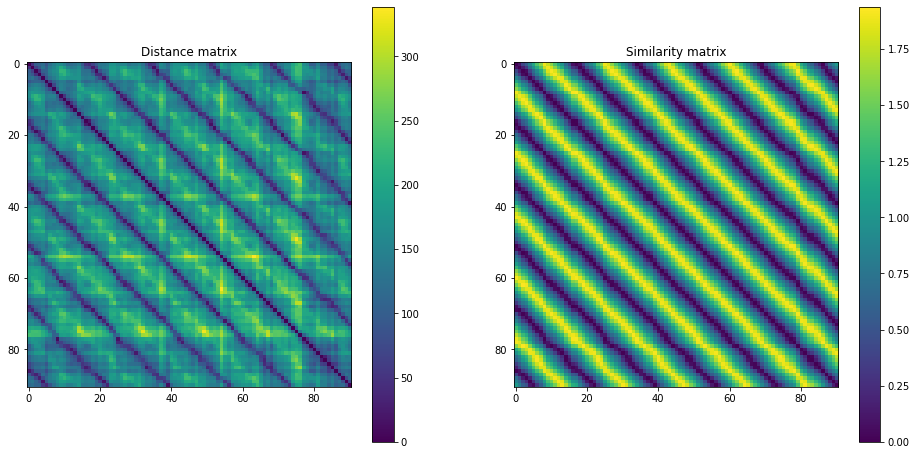

Batch 5/6 (ABL-5 RCA_AP) with 38 sequences


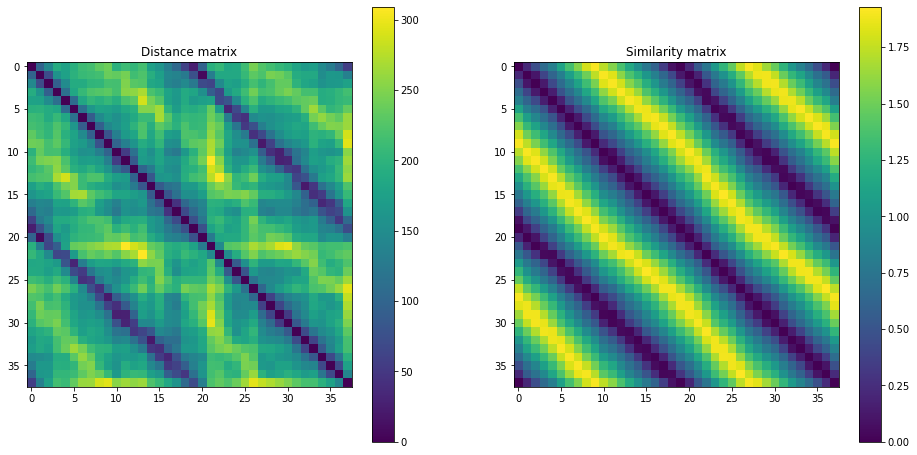

Batch 6/6 (ABL-5 RCA_LAT) with 38 sequences


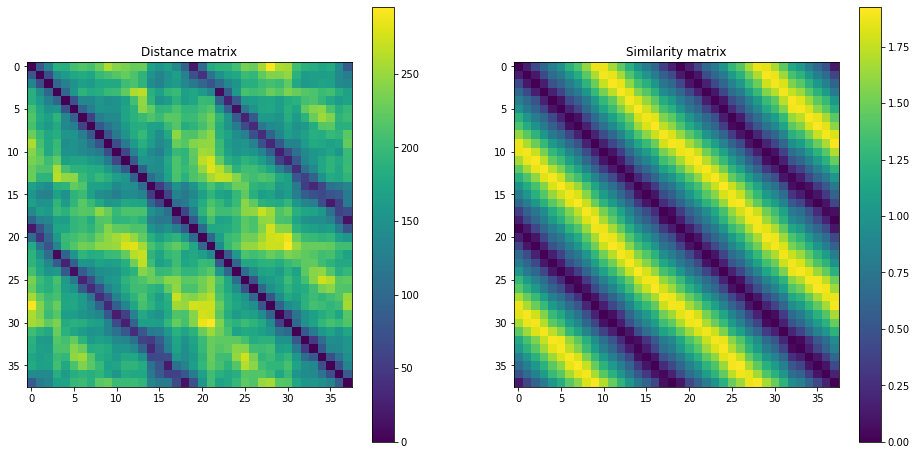

In [4]:
def calc_distance_and_similarity_matrices(embeddings):
    distances = []
    similarities = []
    for i in range(len(embeddings)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
                similarities_i.append(similarities[j][i])
            elif j == i:
                distances_i.append(0)
                similarities_i.append(0)
            else:
                # Distance
                dist_val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(dist_val.cpu().numpy())
                # Similarity
                normalized_embedding_i = embeddings[i] / torch.norm(embeddings[i])
                normalized_embedding_j = embeddings[j] / torch.norm(embeddings[j])
                sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
                similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    all_embeddings = []
    names = []
    for batch_index, sequences in enumerate(test_loader):
        name = sequences[1][0]
        sequences = sequences[0]
        
        # sequences: (batch, video_frame, channel, width, height)
        print(f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
        embeddings = model(sequences[0])
        all_embeddings.append(embeddings)
        names.append(name)
        
        distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices(embeddings)
        
        figure(figsize=(16,8))
        
        plt.subplot(1, 2, 1)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title(f"Distance matrix")
        
        plt.subplot(1, 2, 2)
        plt.imshow(similarity_matrix)
        plt.colorbar()
        plt.title(f"Similarity matrix")
        
        plt.show()

### Compute distance and similarity matrices for video comparison

Combinations of ABL-5
Comparison of ABL-5 LCA_30LAO25CRA and ABL-5 LCA_30LAO25CRA


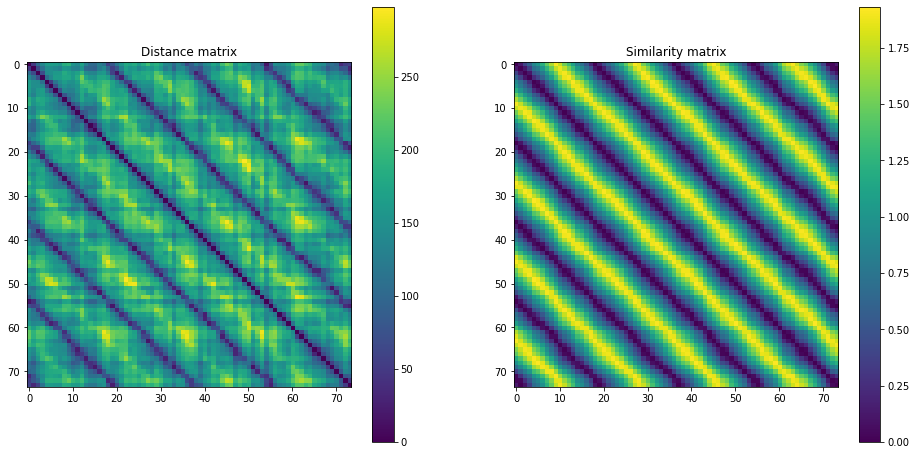

Comparison of ABL-5 LCA_30LAO25CRA and ABL-5 LCA_30RAO


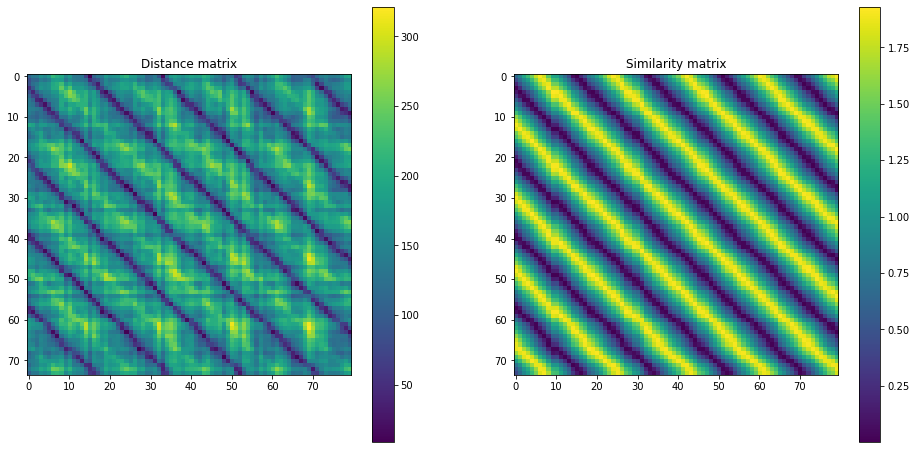

Comparison of ABL-5 LCA_30LAO25CRA and ABL-5 LCA_AP


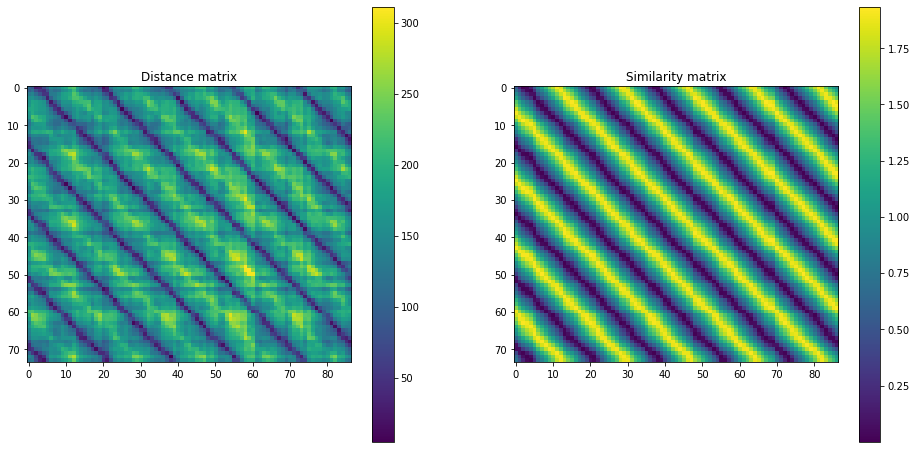

Comparison of ABL-5 LCA_30LAO25CRA and ABL-5 LCA_LAT


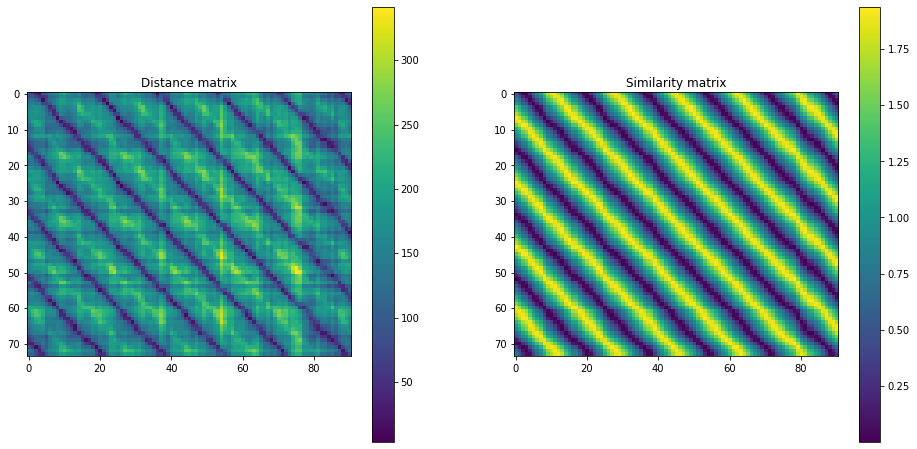

Comparison of ABL-5 LCA_30LAO25CRA and ABL-5 RCA_AP


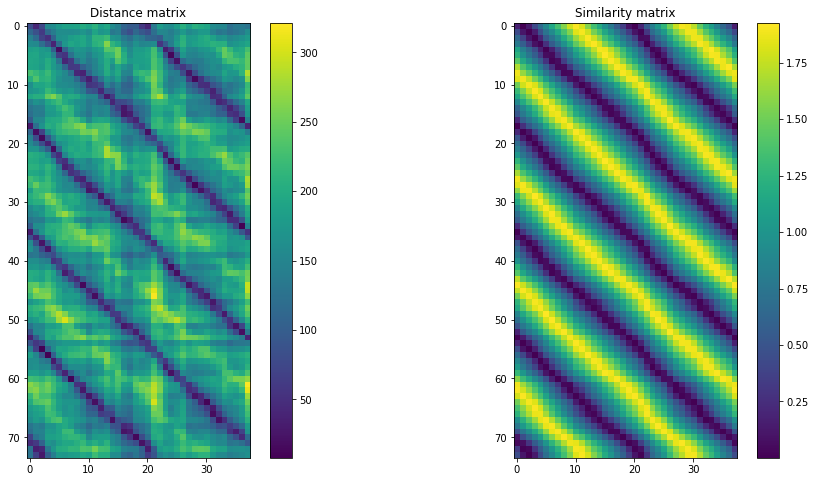

Comparison of ABL-5 LCA_30LAO25CRA and ABL-5 RCA_LAT


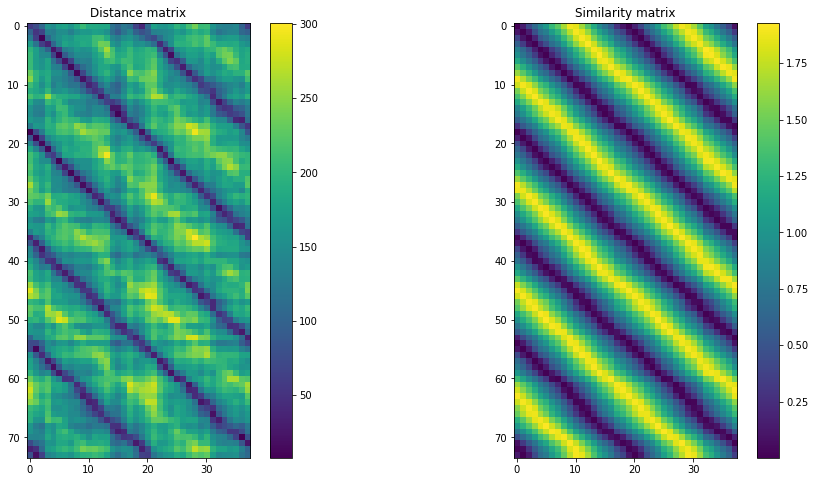

Comparison of ABL-5 LCA_30RAO and ABL-5 LCA_30RAO


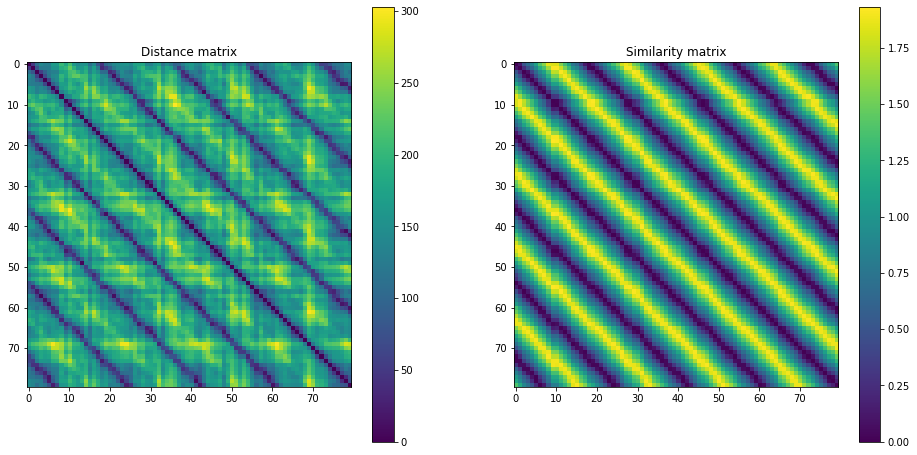

Comparison of ABL-5 LCA_30RAO and ABL-5 LCA_AP


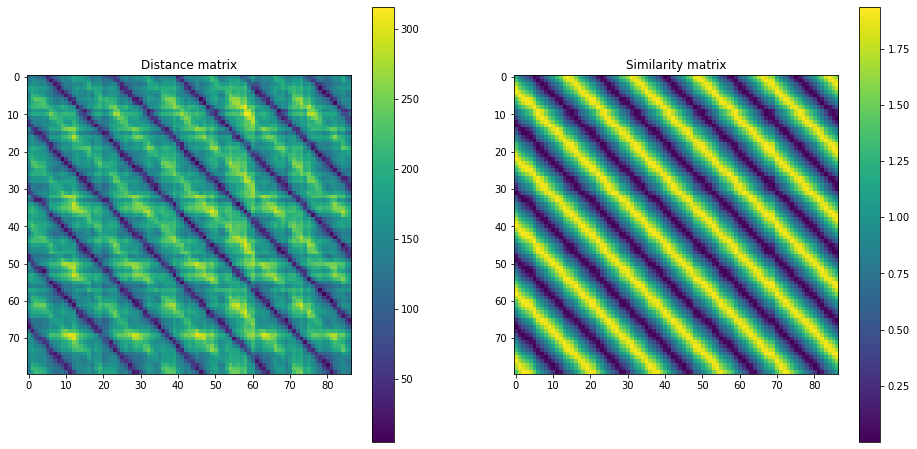

Comparison of ABL-5 LCA_30RAO and ABL-5 LCA_LAT


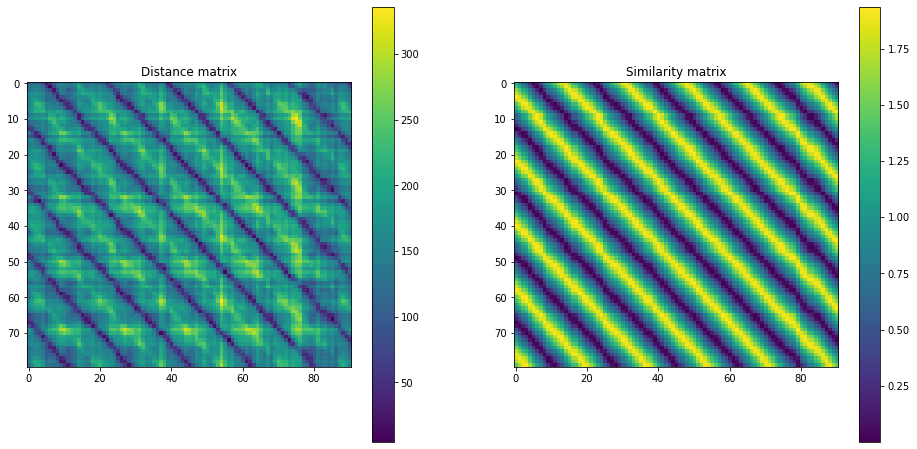

Comparison of ABL-5 LCA_30RAO and ABL-5 RCA_AP


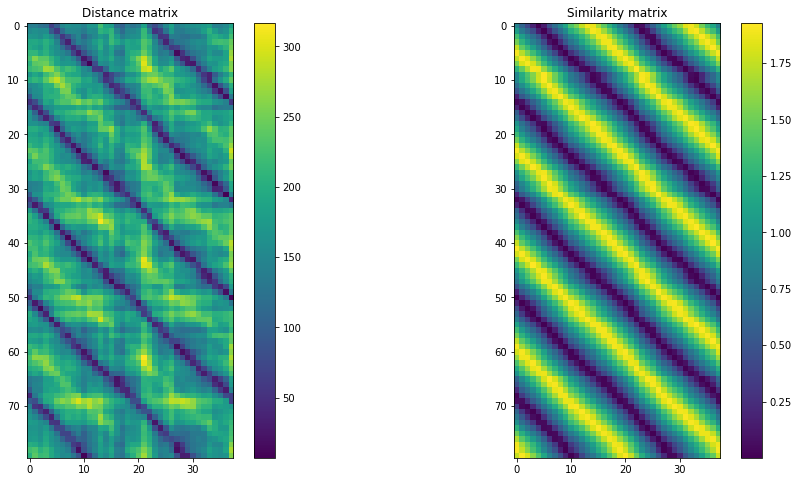

Comparison of ABL-5 LCA_30RAO and ABL-5 RCA_LAT


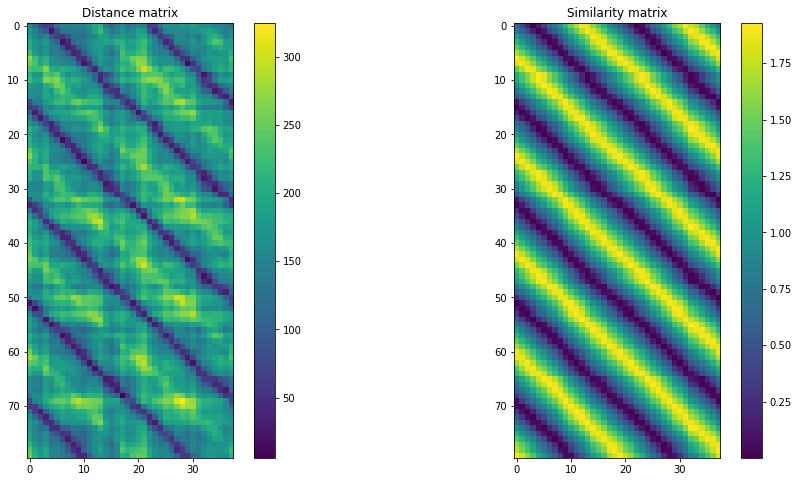

Comparison of ABL-5 LCA_AP and ABL-5 LCA_AP


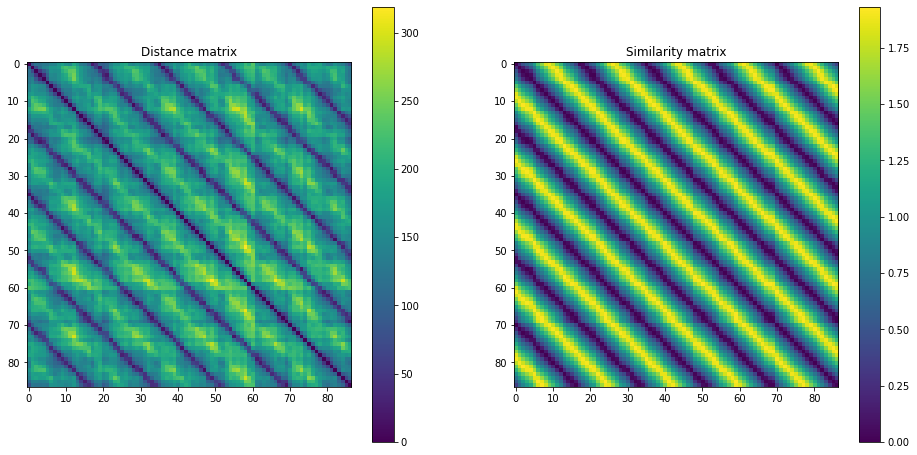

Comparison of ABL-5 LCA_AP and ABL-5 LCA_LAT


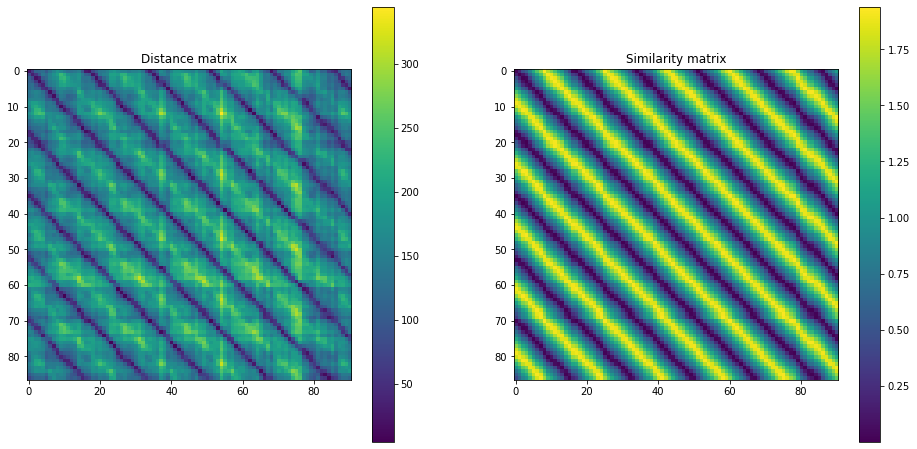

Comparison of ABL-5 LCA_AP and ABL-5 RCA_AP


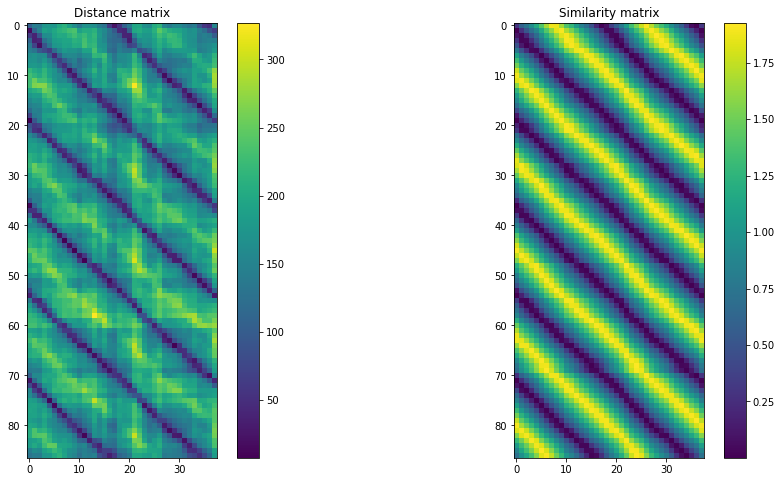

Comparison of ABL-5 LCA_AP and ABL-5 RCA_LAT


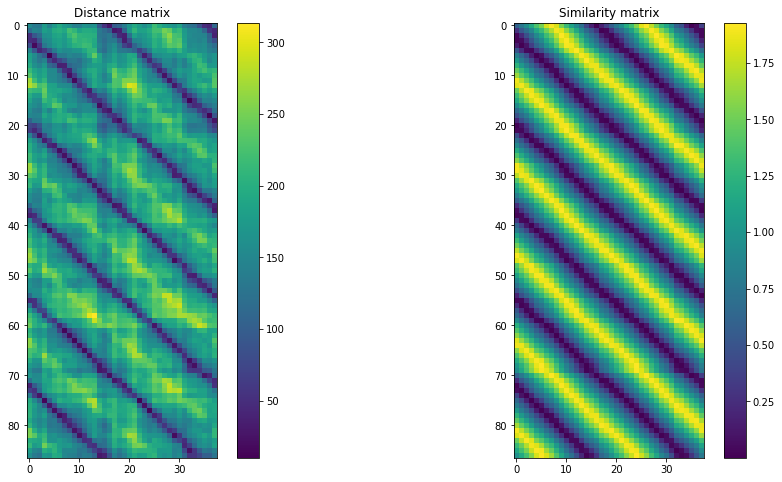

Comparison of ABL-5 LCA_LAT and ABL-5 LCA_LAT


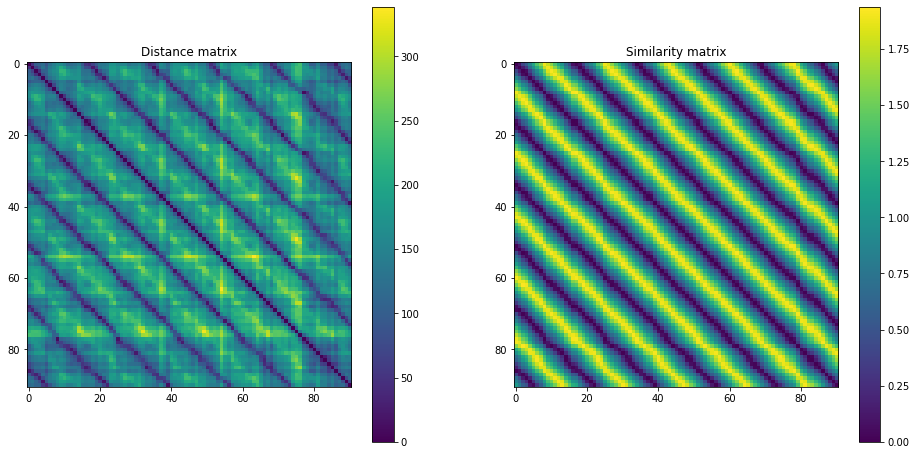

Comparison of ABL-5 LCA_LAT and ABL-5 RCA_AP


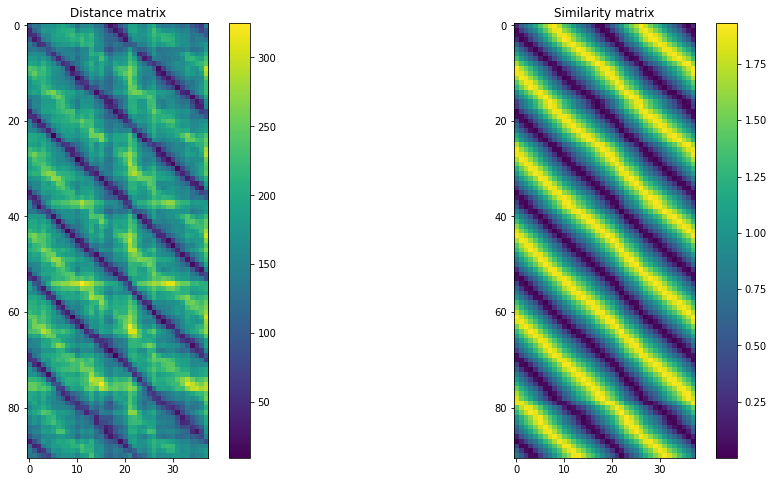

Comparison of ABL-5 LCA_LAT and ABL-5 RCA_LAT


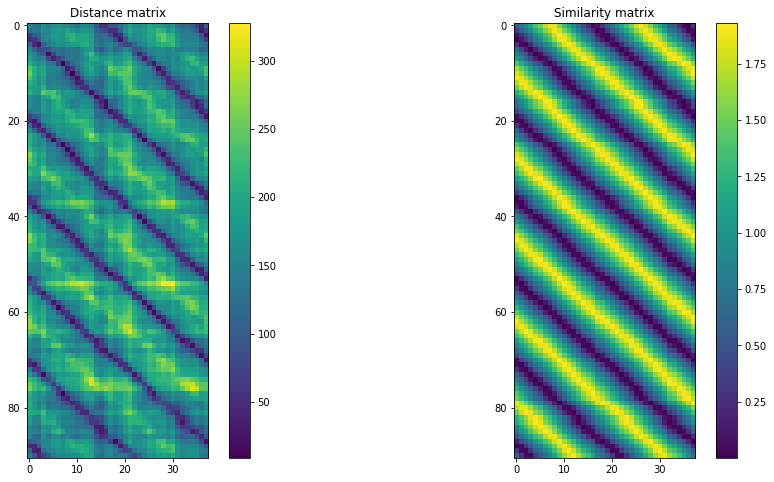

Comparison of ABL-5 RCA_AP and ABL-5 RCA_AP


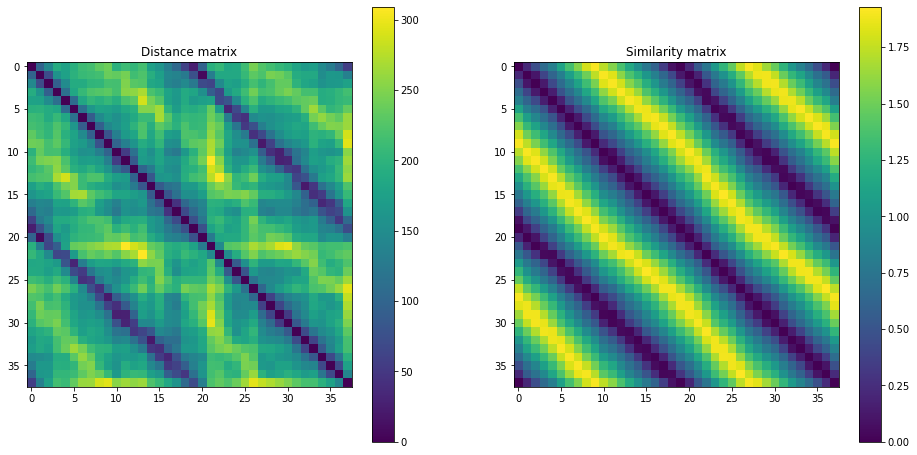

Comparison of ABL-5 RCA_AP and ABL-5 RCA_LAT


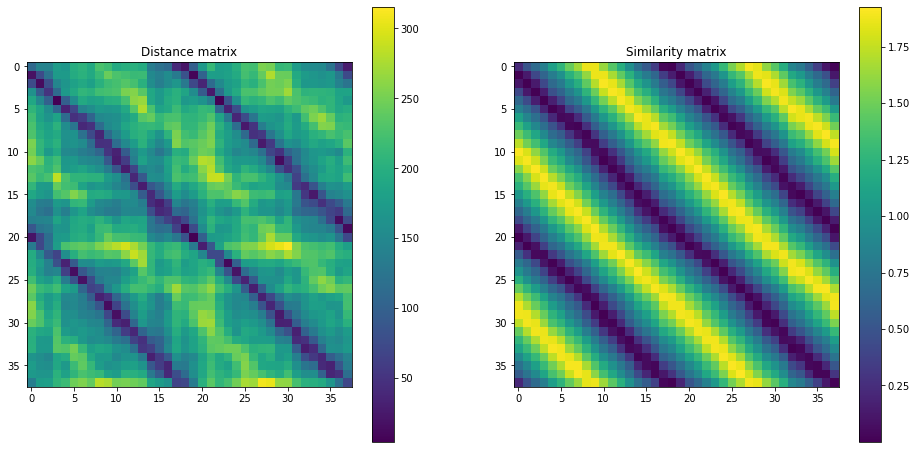

Comparison of ABL-5 RCA_LAT and ABL-5 RCA_LAT


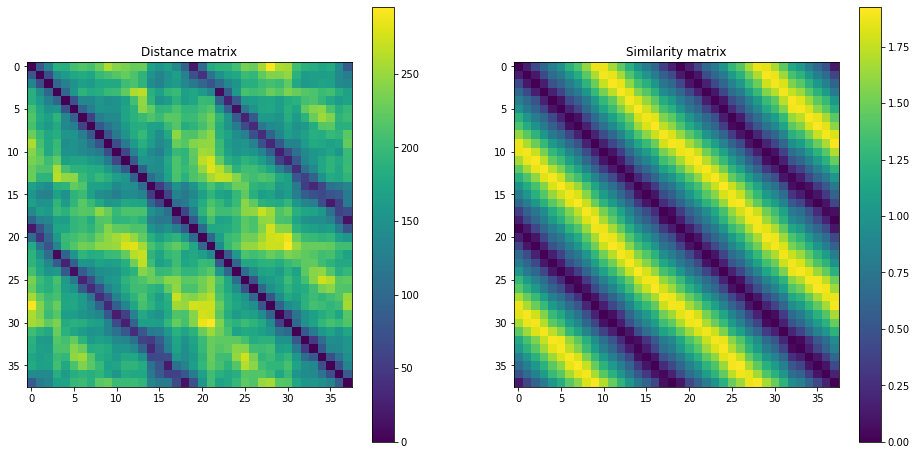

In [5]:
def calc_distance_and_similarity_matrices2(embeddings1, embeddings2):
    distances = []
    similarities = []
    for i in range(len(embeddings1)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings2)):
            # Distance
            dist_val = torch.sum(torch.abs(embeddings1[i] - embeddings2[j]))
            distances_i.append(dist_val.cpu().numpy())
            # Similarity
            normalized_embedding_i = embeddings1[i] / torch.norm(embeddings1[i])
            normalized_embedding_j = embeddings2[j] / torch.norm(embeddings2[j])
            sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
            similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    try:
        all_embeddings
    except NameError:
        all_embeddings = []
        compute_embeddings = True
    else:
        compute_embeddings = False
    if compute_embeddings:
        print (f"Computing embeddings")
        names = []
        for batch_index, sequences in enumerate(test_loader):
            name = sequences[1][0]
            sequences = sequences[0]

            # sequences: (batch, video_frame, channel, width, height)
            print(f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
            embeddings = model(sequences[0])
            all_embeddings.append(embeddings)
            names.append(name)
    
    distance_matrices = {}
    similarity_matrices = {}
    current_name = None
    for i in range(len(all_embeddings)):
        name_i = names[i].split(' ')[0]
        if not name_i == current_name:
            print(f"Combinations of {name_i}")
        distance_matrices[names[i]] = {}
        similarity_matrices[names[i]] = {}
        current_name = name_i
        for j in range(i, len(all_embeddings)):
            if name_i == names[j].split(' ')[0]:
                print(f"Comparison of {names[i]} and {names[j]}")
                distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices2(all_embeddings[i], all_embeddings[j])
                distance_matrices[names[i]][names[j]] = distance_matrix
                similarity_matrices[names[i]][names[j]] = similarity_matrix
                
                figure(figsize=(16,8))

                plt.subplot(1, 2, 1)
                plt.imshow(distance_matrix)
                plt.colorbar()
                plt.title(f"Distance matrix")

                plt.subplot(1, 2, 2)
                plt.imshow(similarity_matrix)
                plt.colorbar()
                plt.title(f"Similarity matrix")

                plt.show()

## Pathfinding

distance_matrix (74, 74)
ground_truth (74, 74)


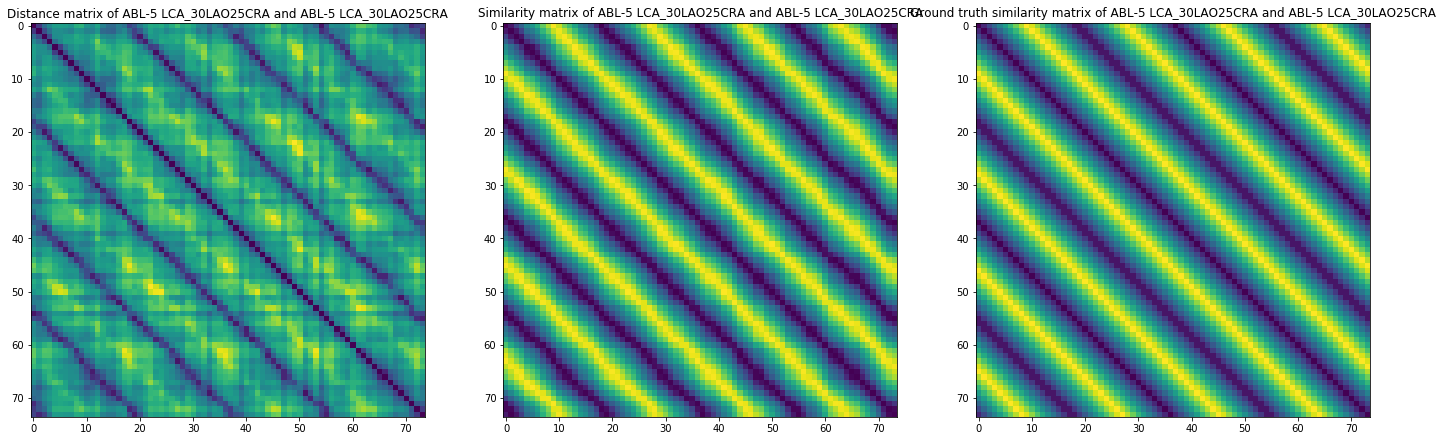

Mean score: 0.8978469995419147 for 236 scores


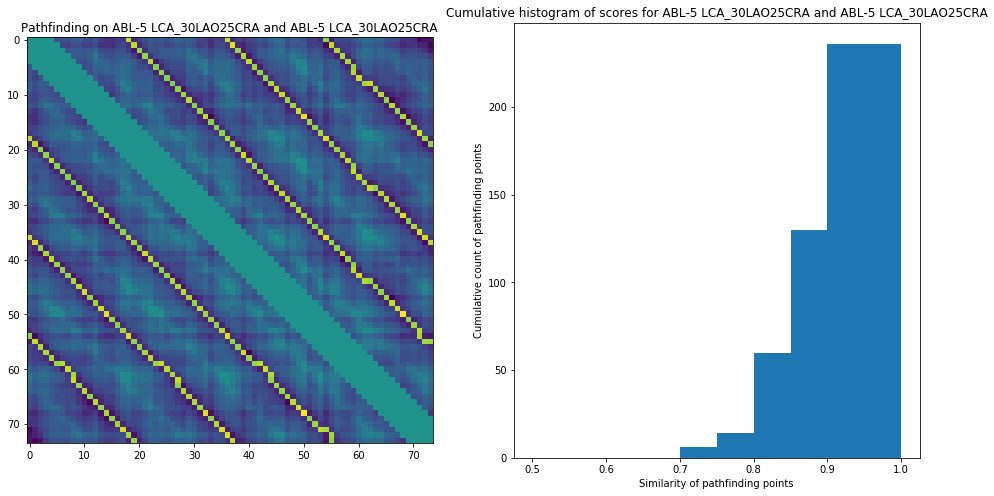

Mean score: 0.7346175963197241 for 376 scores


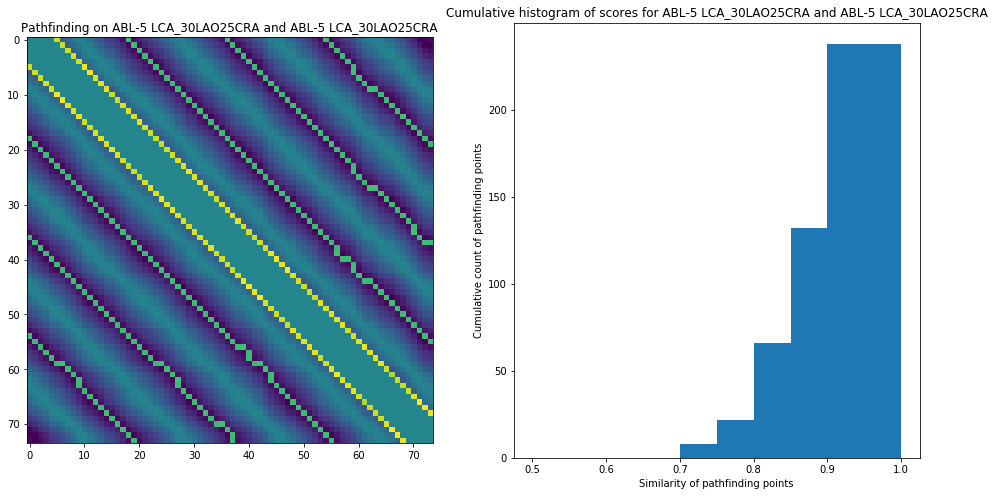

distance_matrix (74, 80)
ground_truth (74, 80)


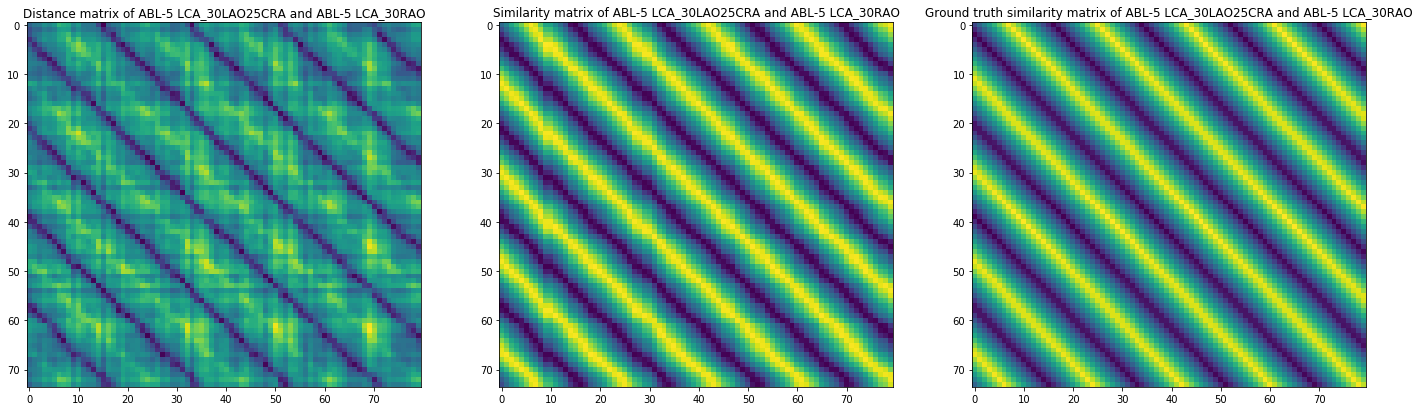

Mean score: 0.934525702172761 for 340 scores


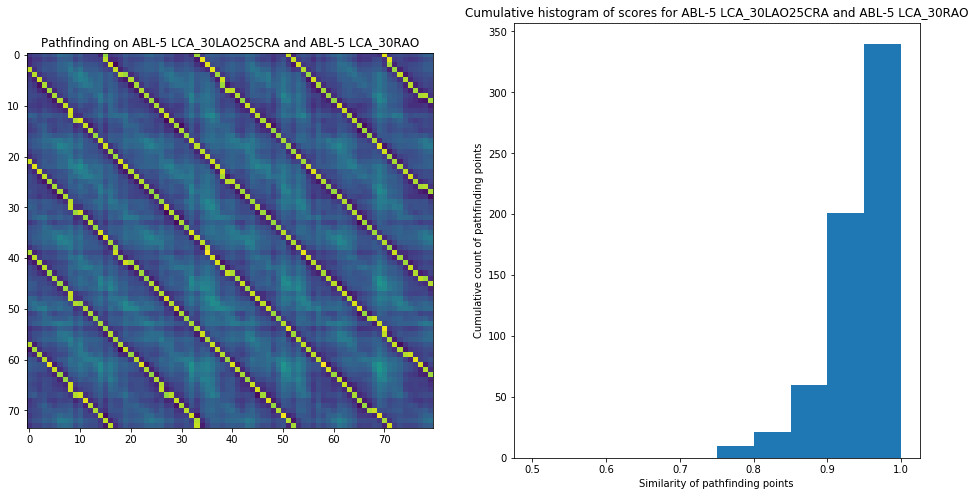

Mean score: 0.9335136886157295 for 343 scores


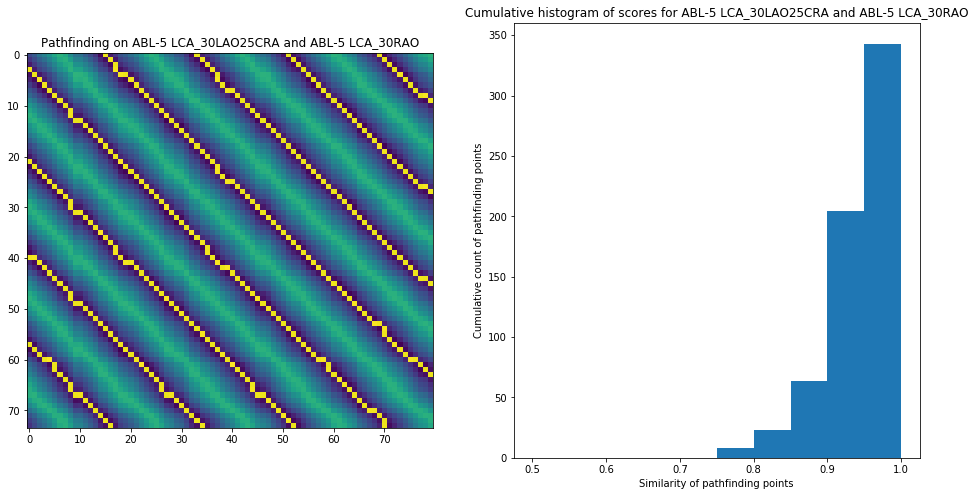

distance_matrix (74, 87)
ground_truth (74, 87)


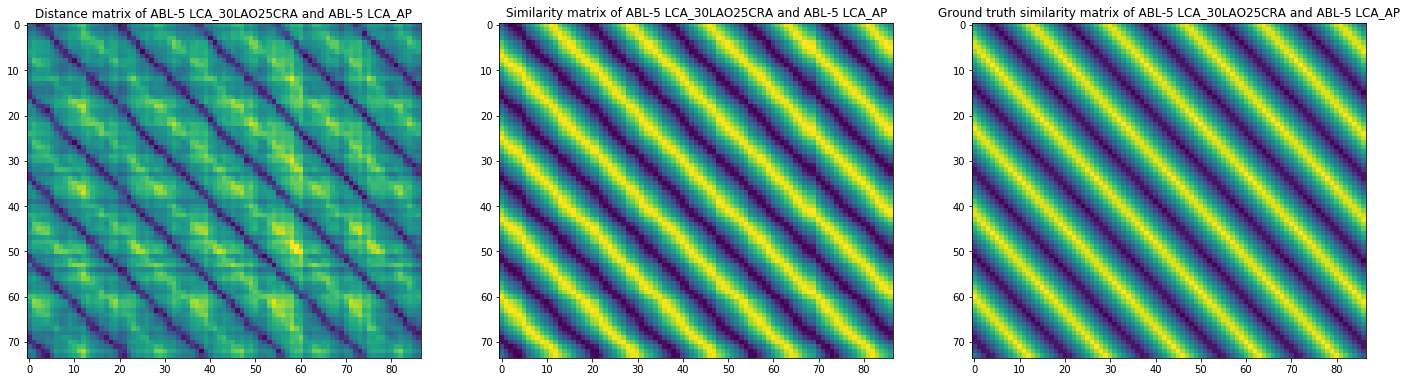

Mean score: 0.9074909824435442 for 372 scores


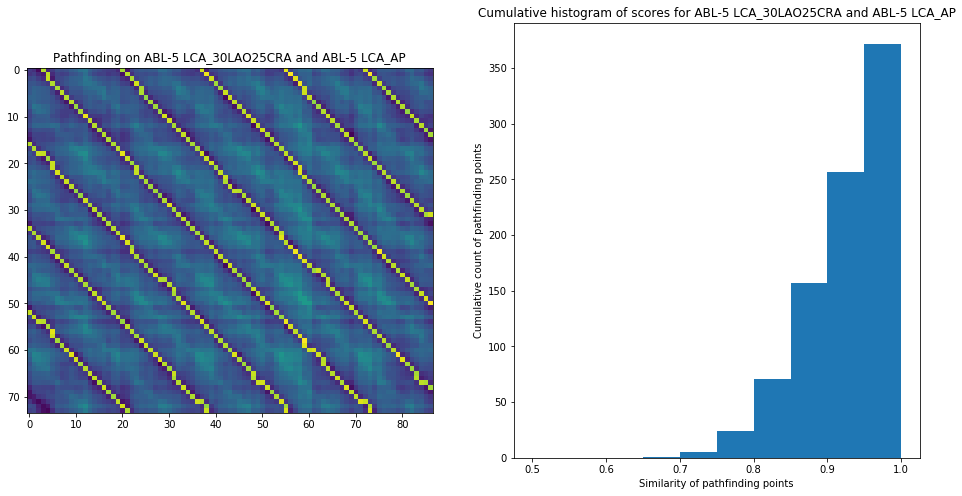

Mean score: 0.908300560622542 for 380 scores


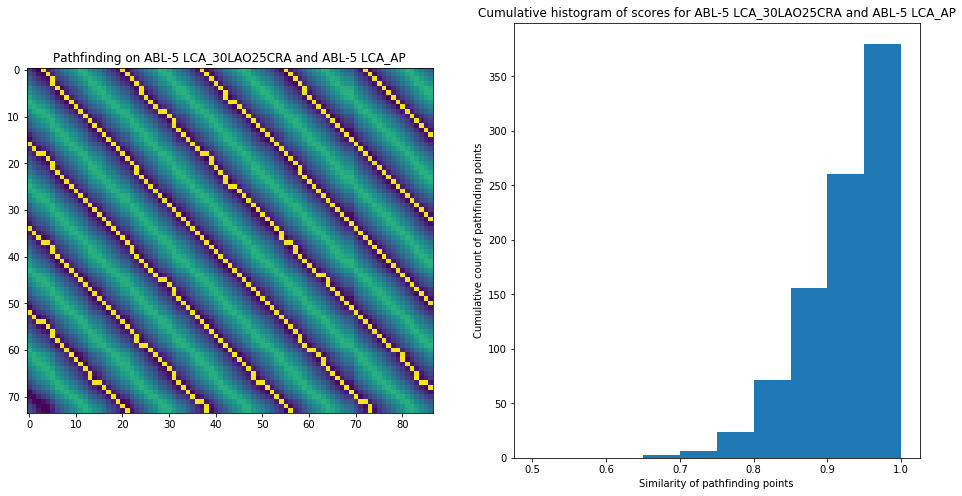

distance_matrix (74, 91)
ground_truth (74, 91)


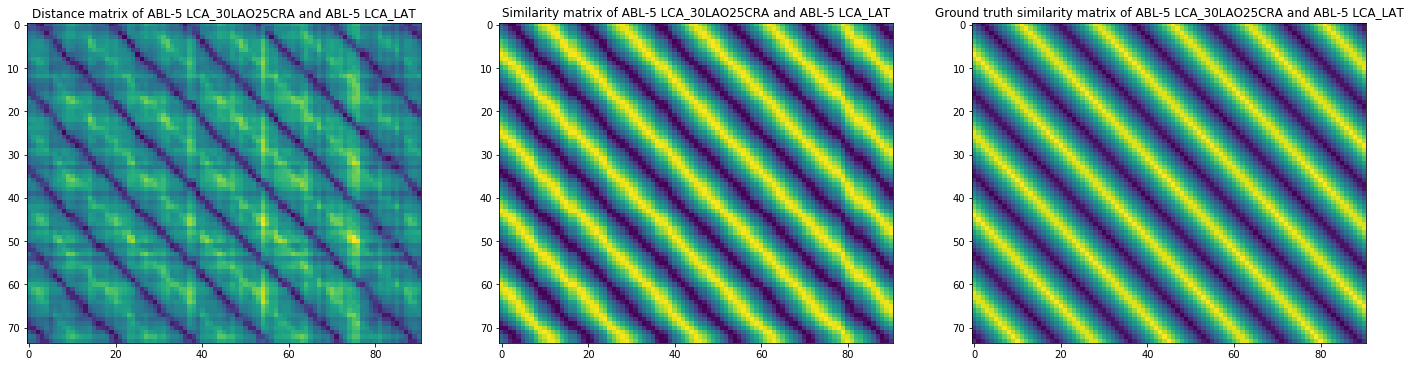

Mean score: 0.9114403636571123 for 406 scores


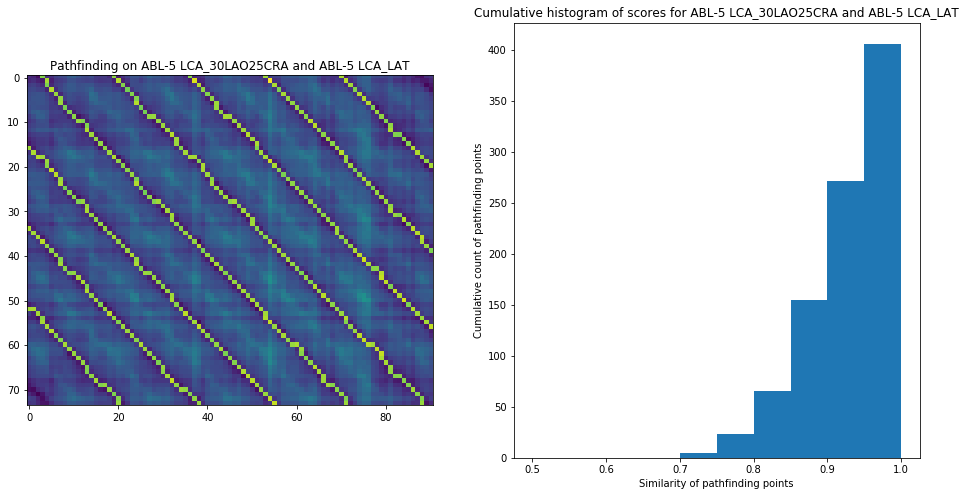

Mean score: 0.9080763226041678 for 413 scores


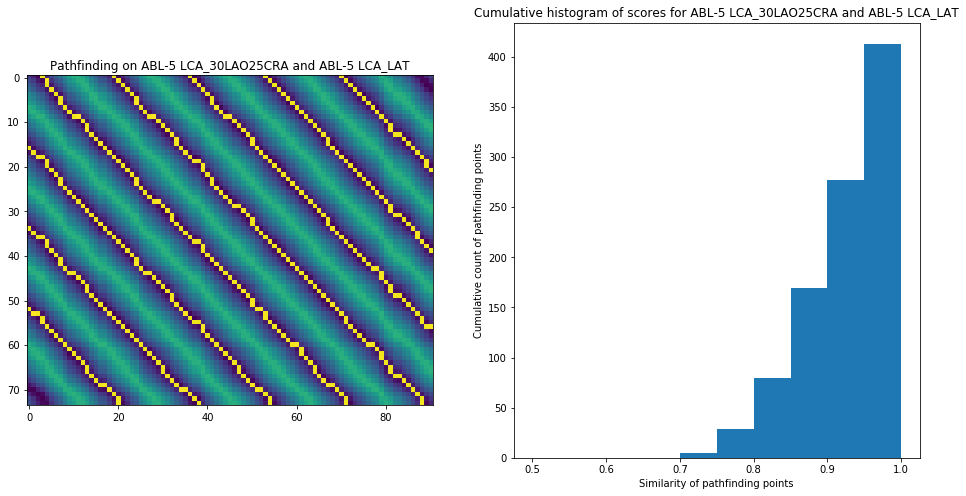

distance_matrix (74, 38)
ground_truth (74, 38)


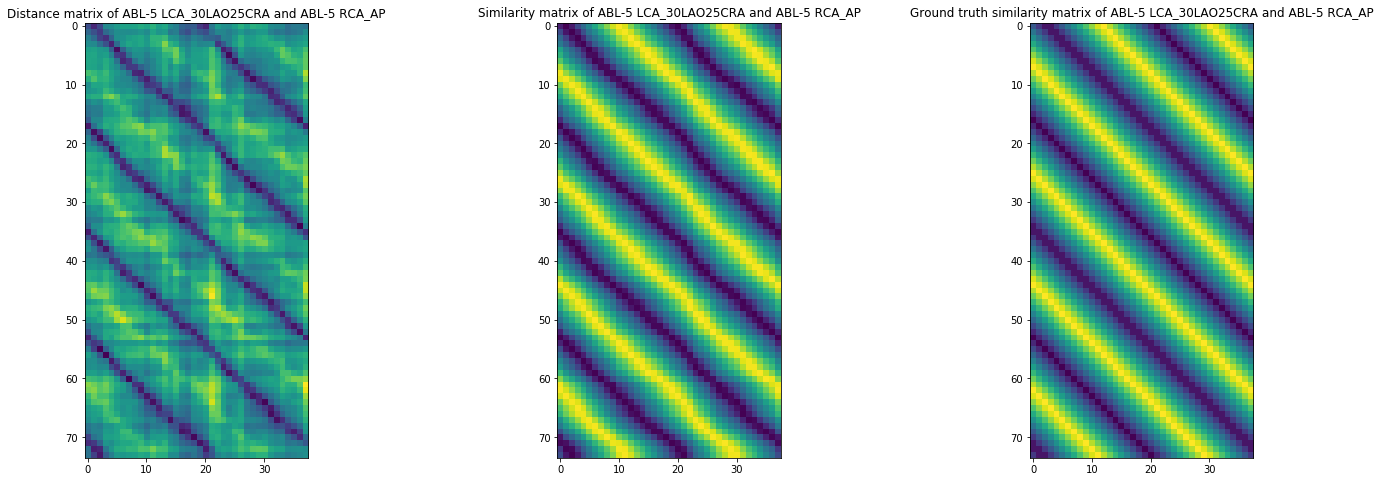

Mean score: 0.9131756756756758 for 160 scores


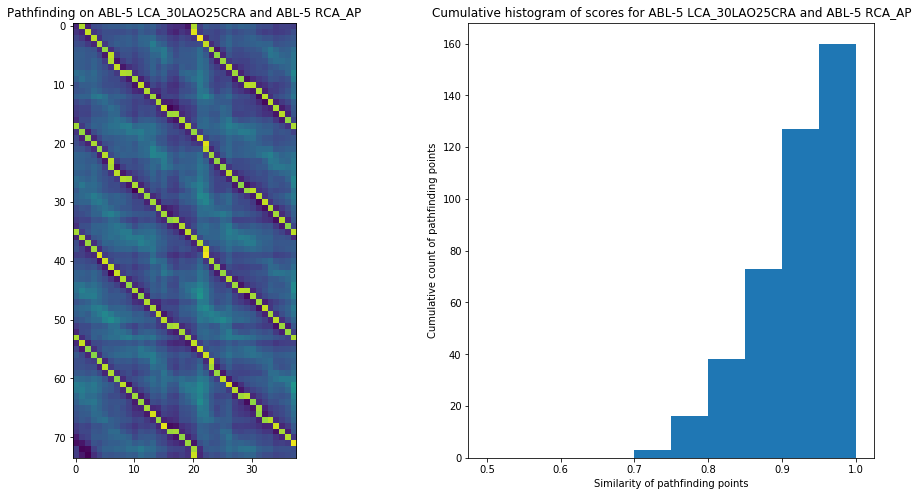

Mean score: 0.9069069069069068 for 162 scores


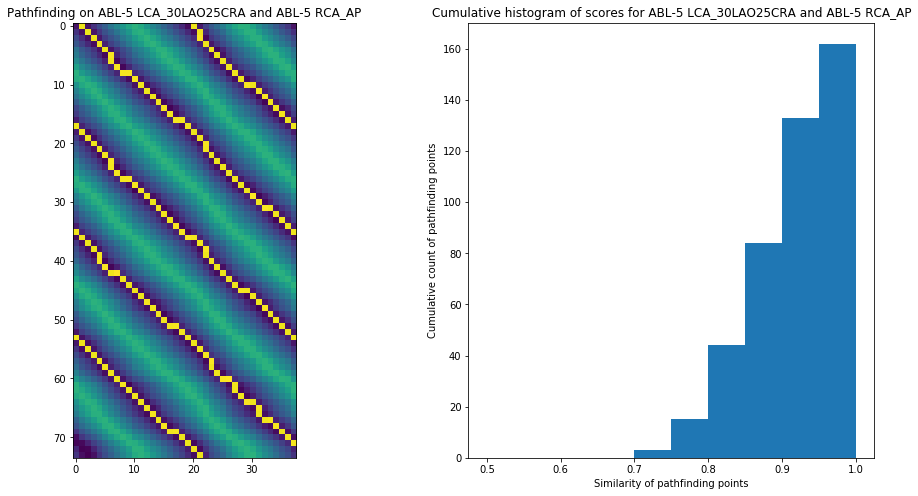

distance_matrix (74, 38)
ground_truth (74, 38)


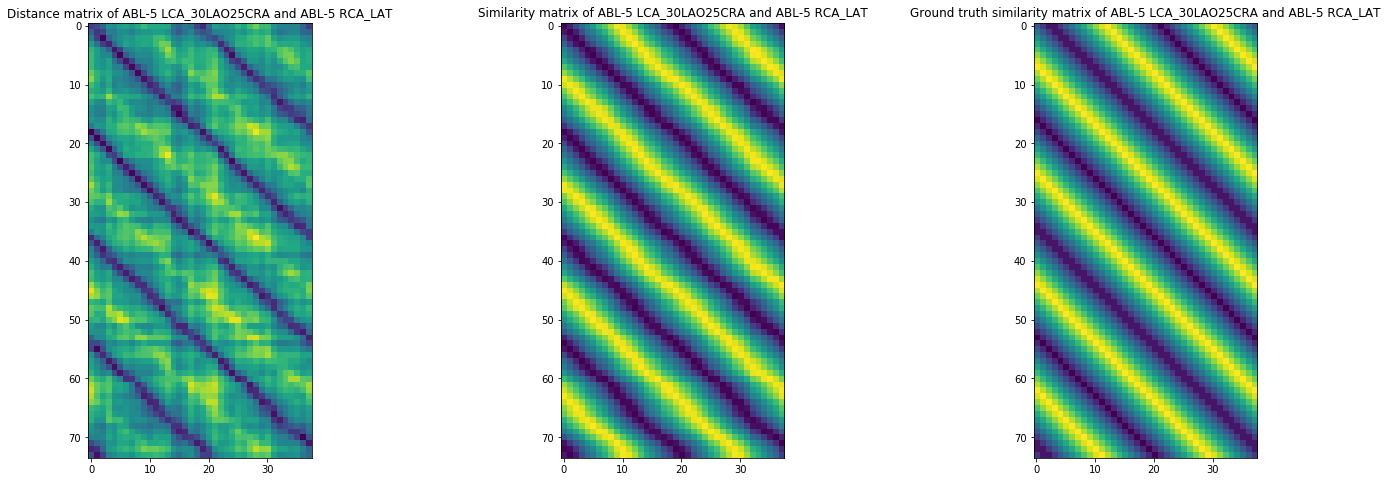

Mean score: 0.8528908655490933 for 158 scores


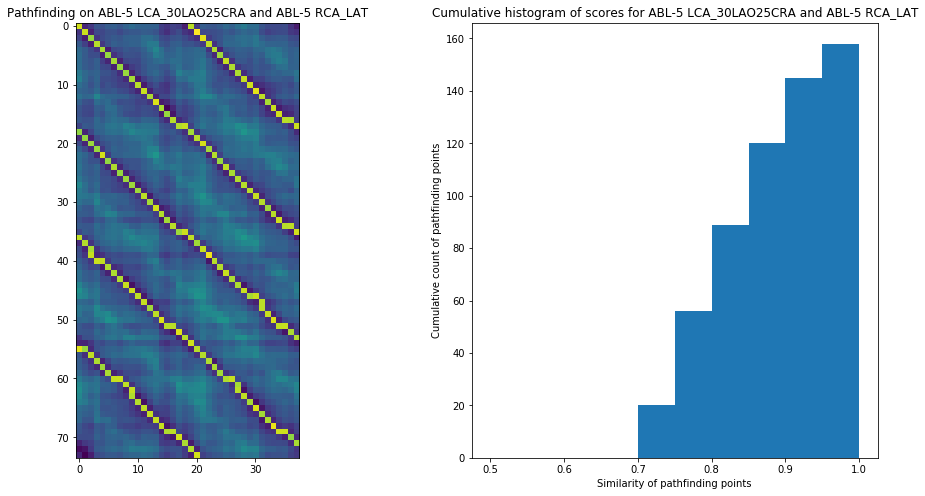

Mean score: 0.8520443520443519 for 156 scores


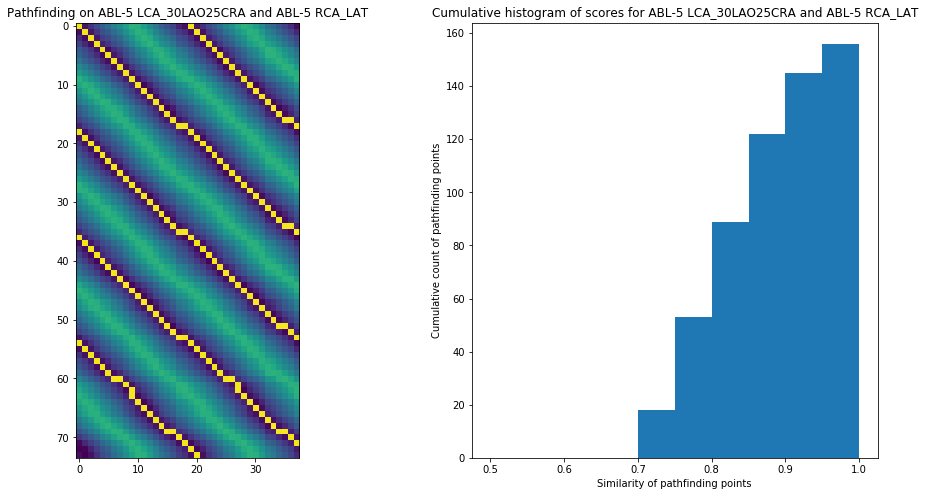

distance_matrix (80, 80)
ground_truth (80, 80)


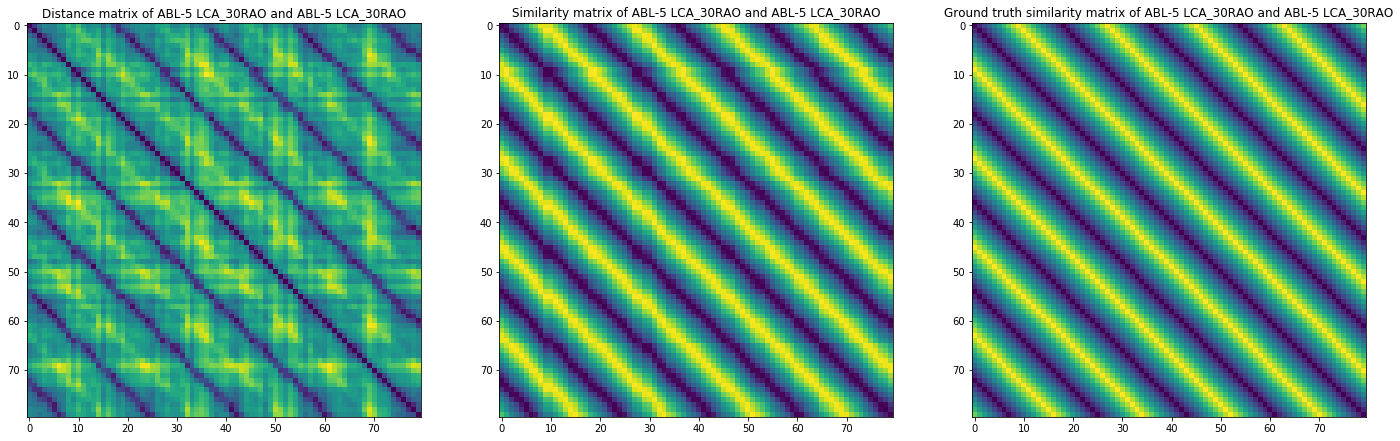

Mean score: 0.9764801297648013 for 274 scores


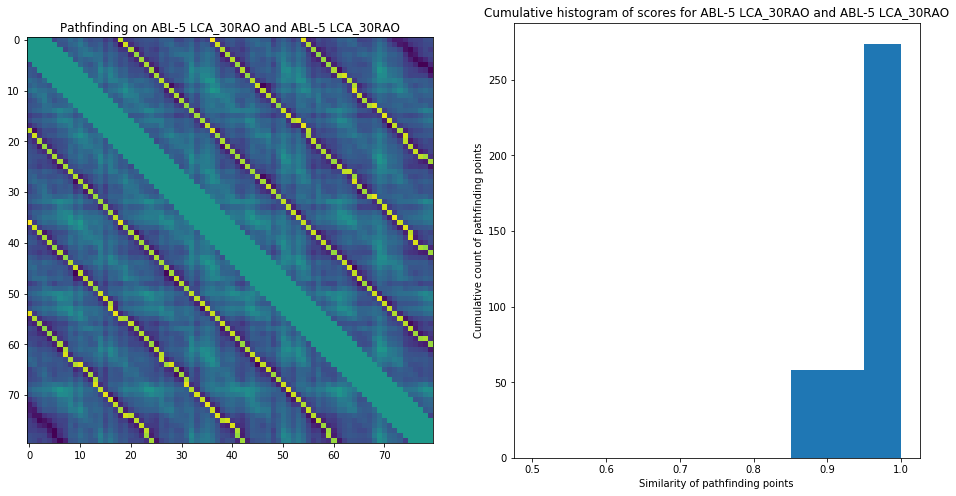

Mean score: 0.7887840670859539 for 424 scores


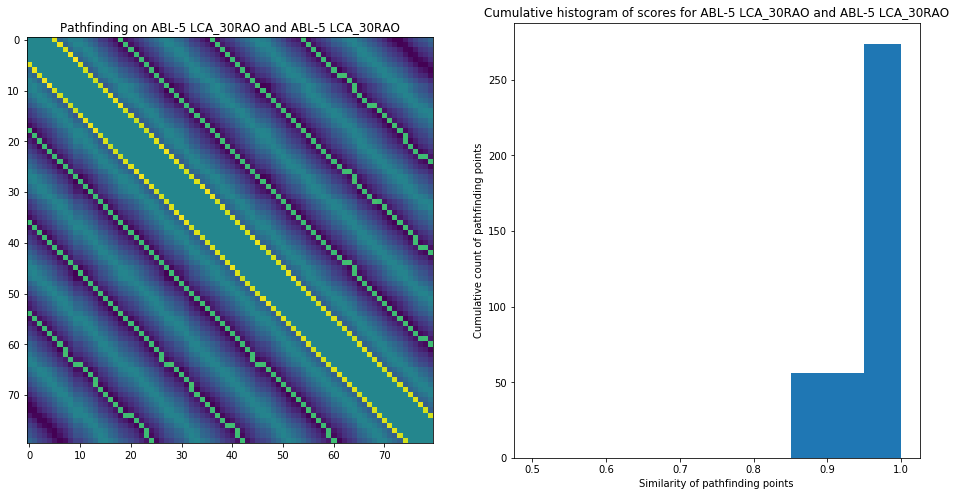

distance_matrix (80, 87)
ground_truth (80, 87)


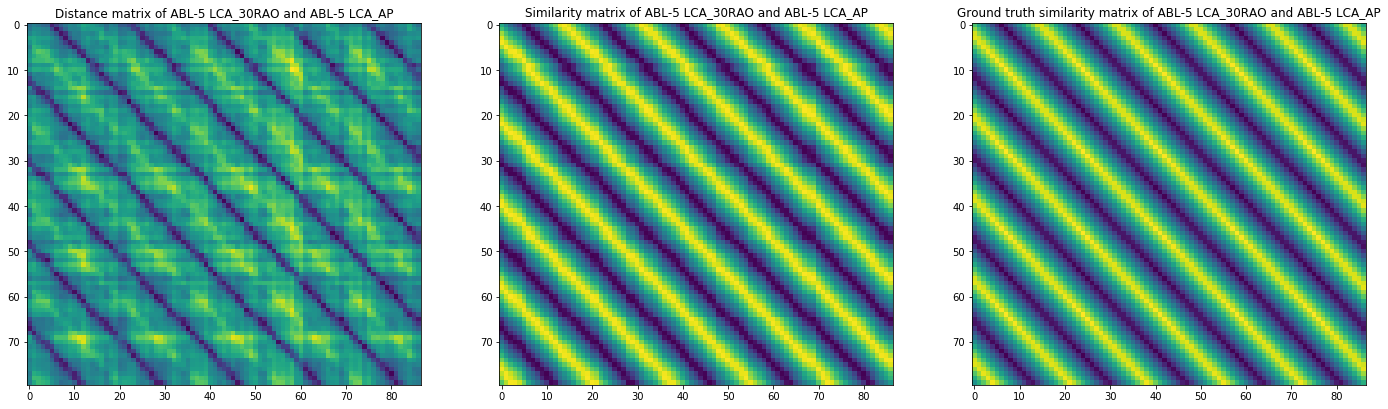

Mean score: 0.9237685318029651 for 410 scores


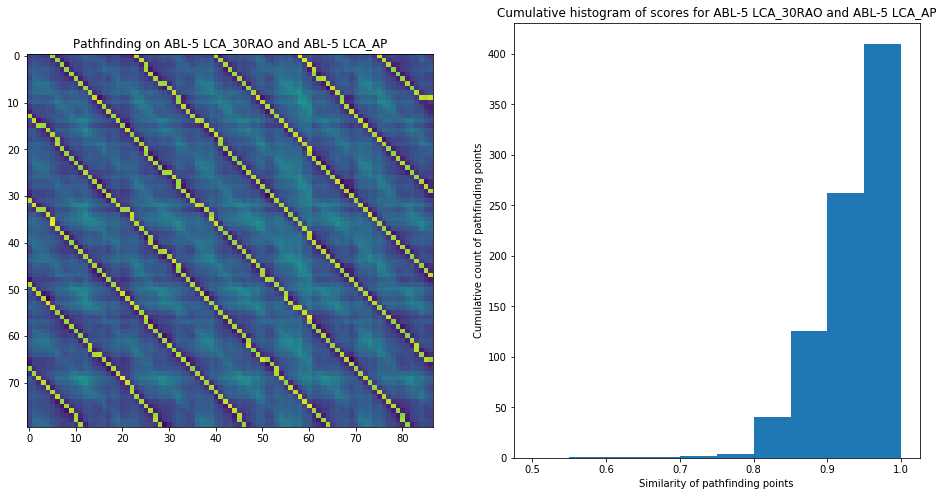

Mean score: 0.9243247499803134 for 415 scores


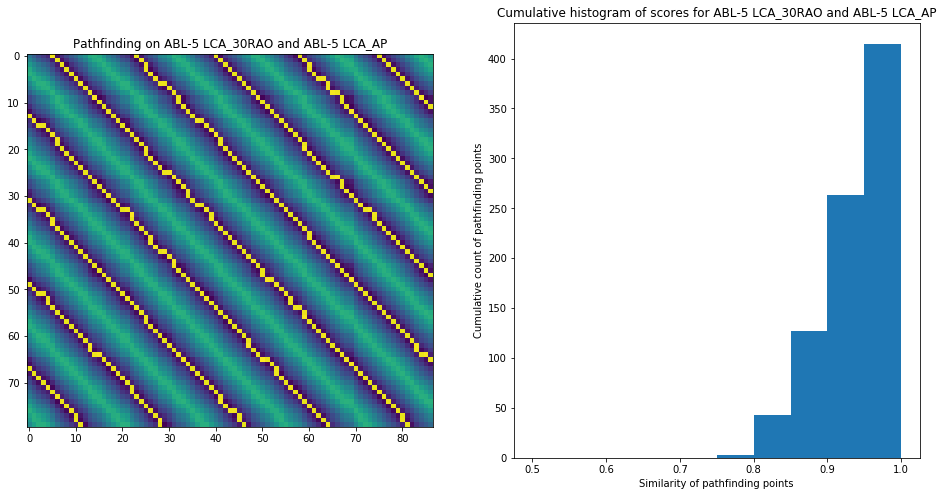

distance_matrix (80, 91)
ground_truth (80, 91)


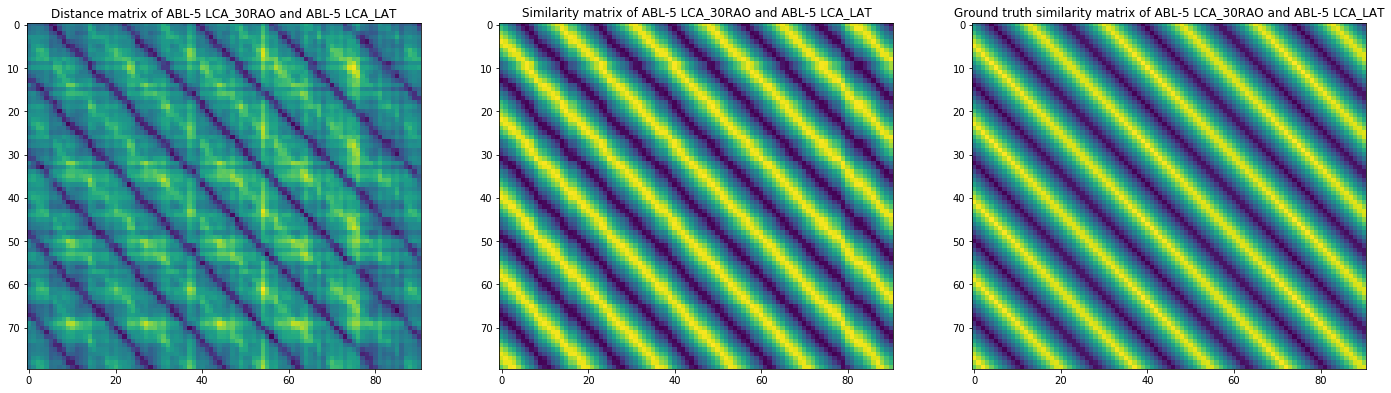

Mean score: 0.9317639471138344 for 443 scores


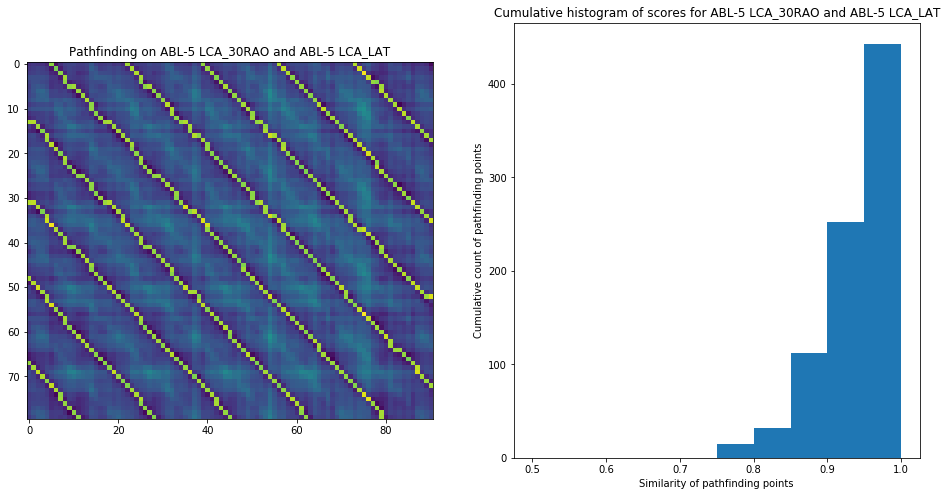

Mean score: 0.9308007847333691 for 445 scores


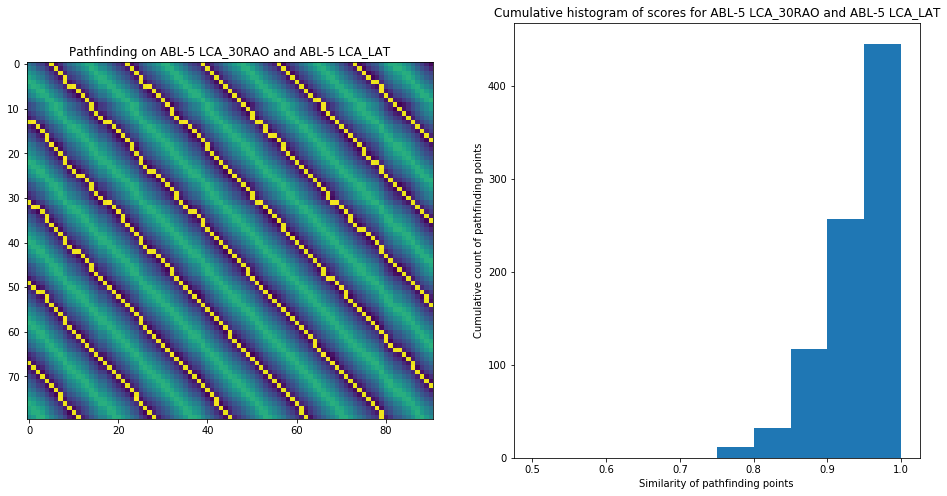

distance_matrix (80, 38)
ground_truth (80, 38)


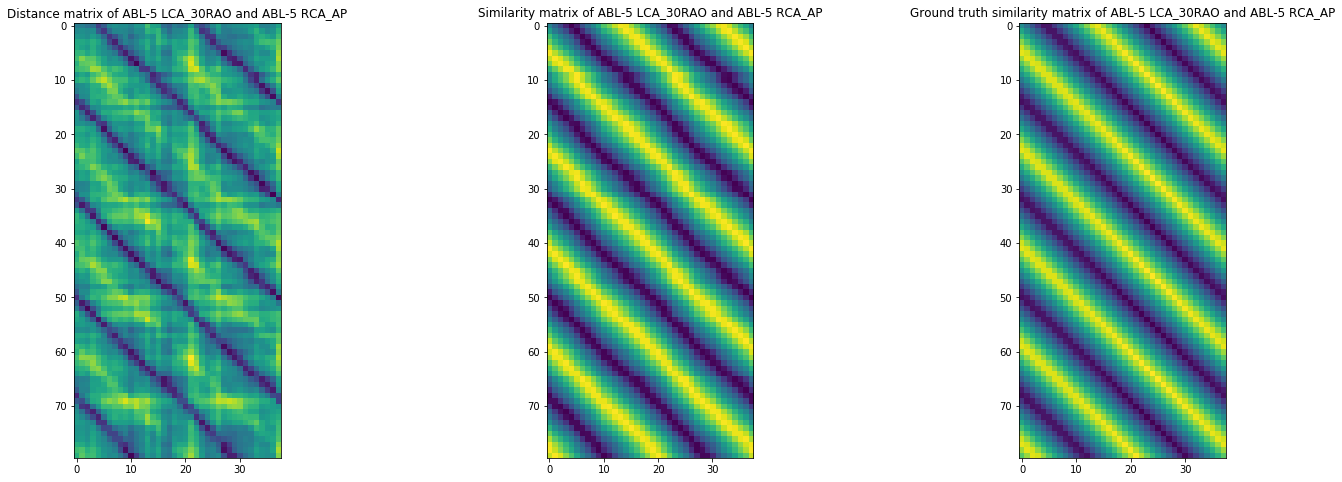

Mean score: 0.9332530204623228 for 172 scores


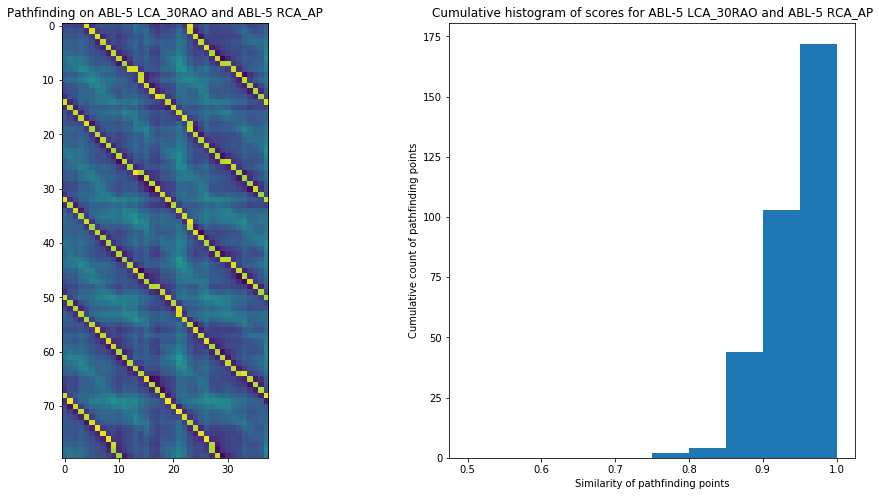

Mean score: 0.9315558332899374 for 173 scores


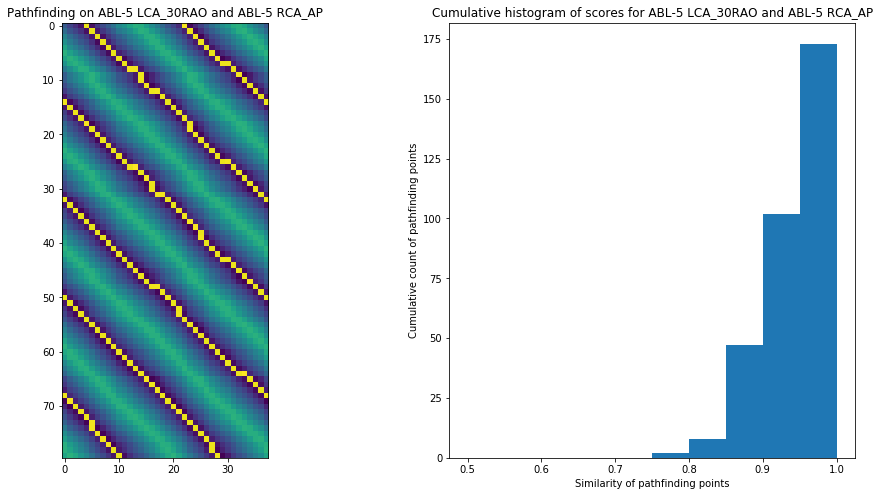

distance_matrix (80, 38)
ground_truth (80, 38)


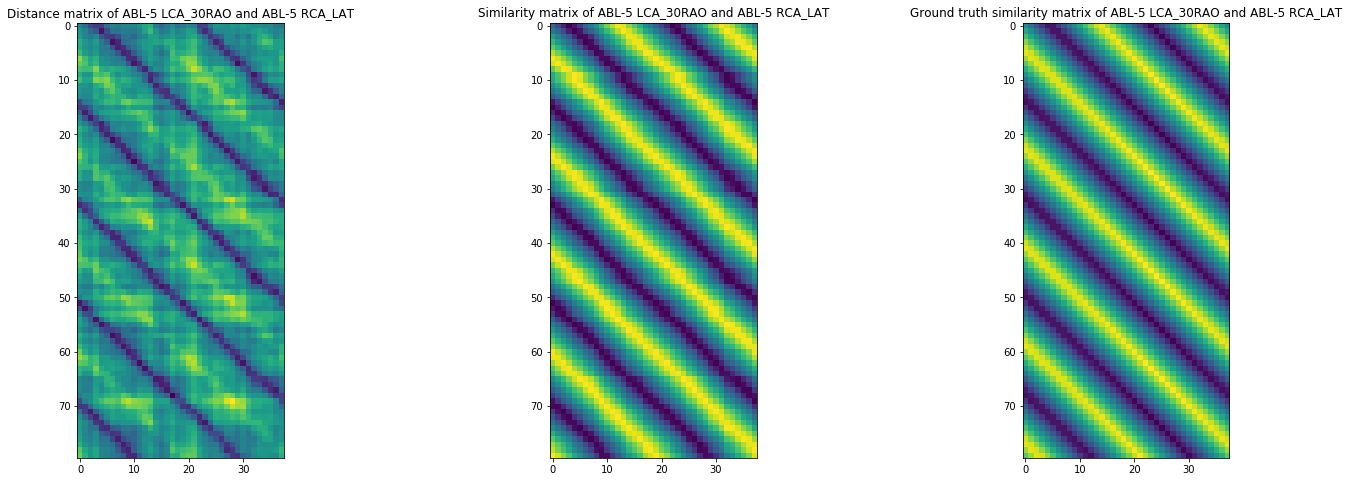

Mean score: 0.8625643187046695 for 171 scores


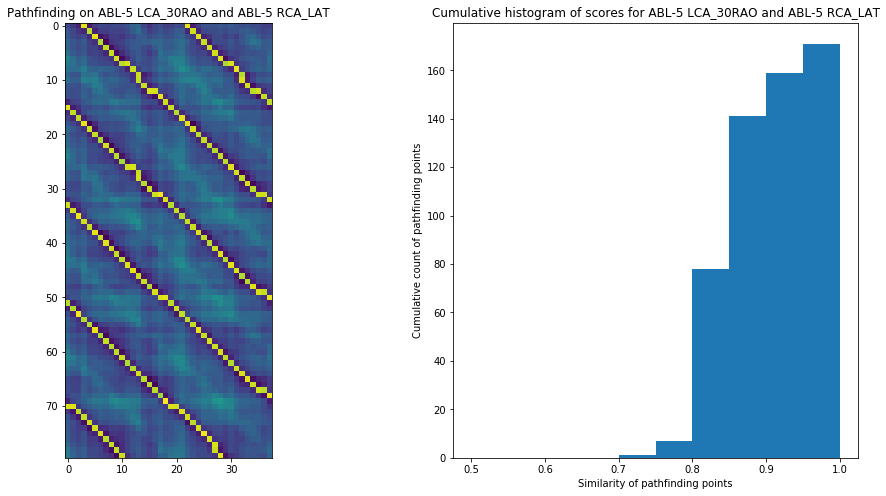

Mean score: 0.8612682449891754 for 172 scores


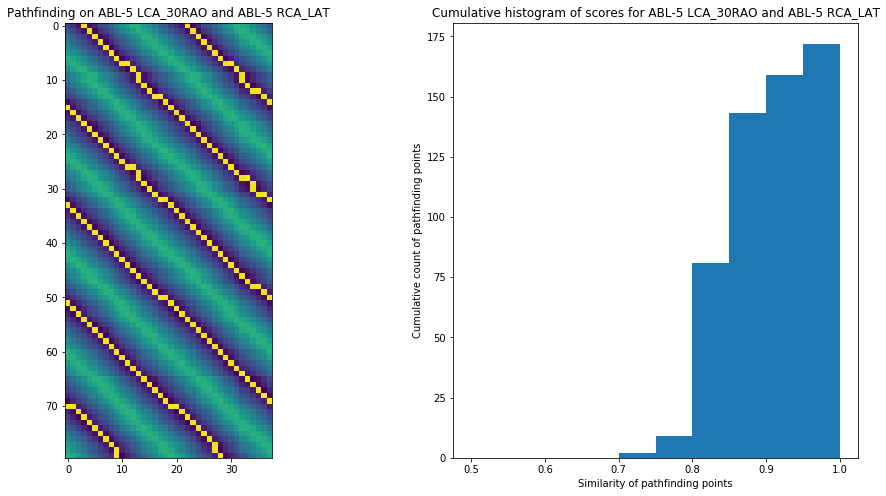

distance_matrix (87, 87)
ground_truth (87, 87)


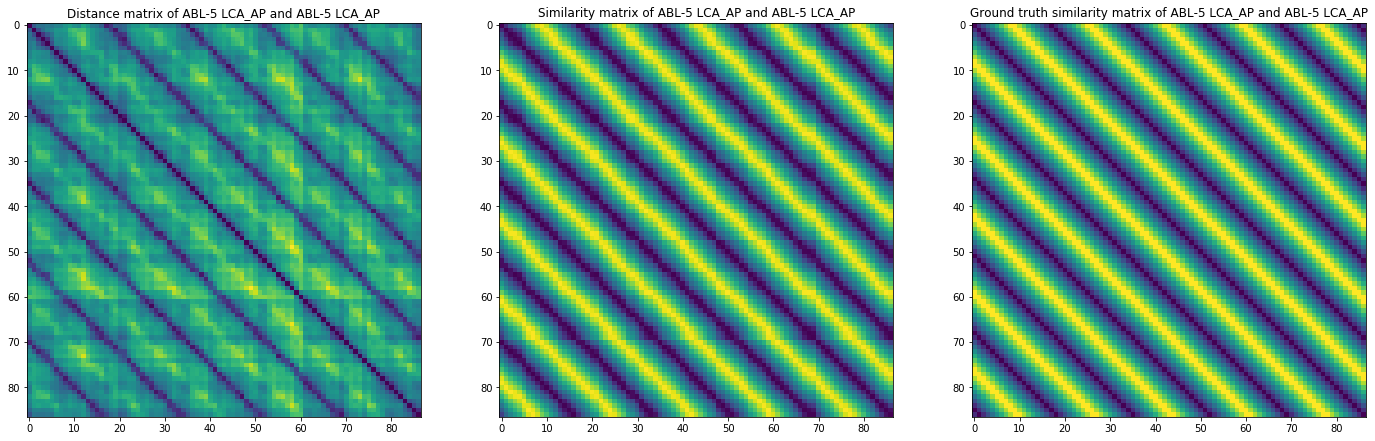

Mean score: 0.891402714932127 for 364 scores


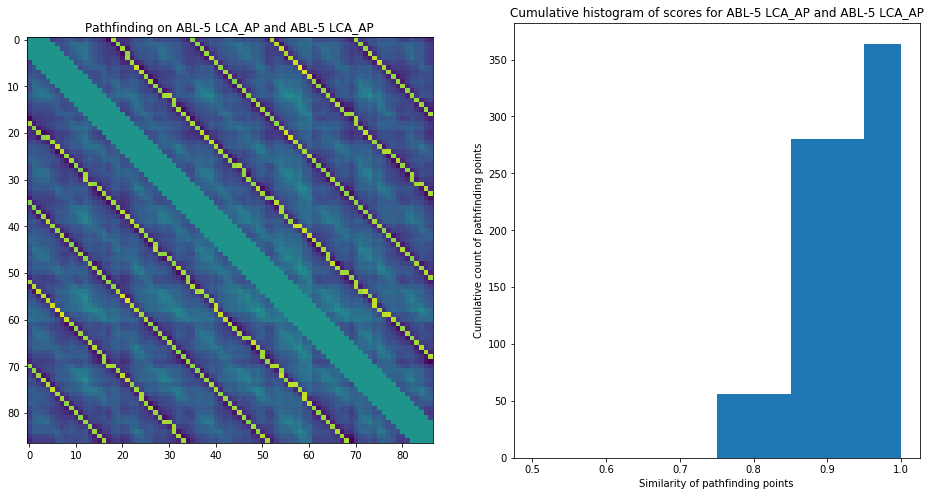

Mean score: 0.7413527208636264 for 534 scores


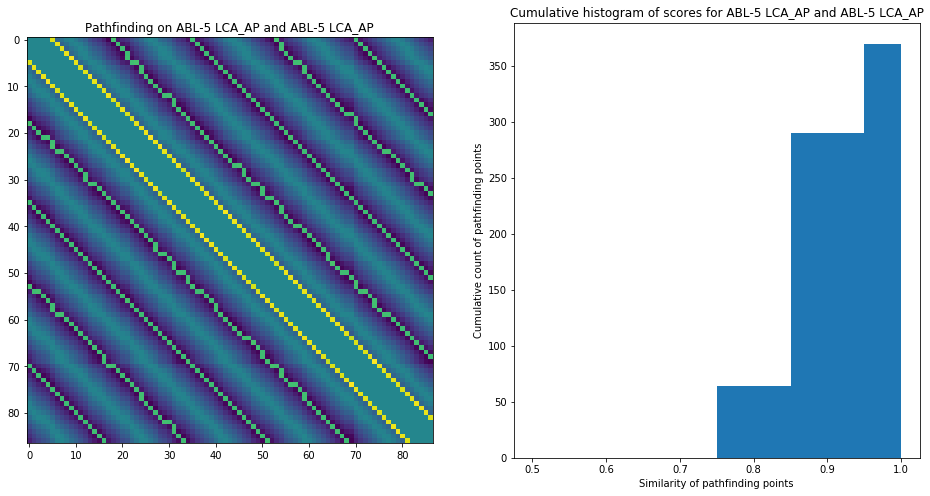

distance_matrix (87, 91)
ground_truth (87, 91)


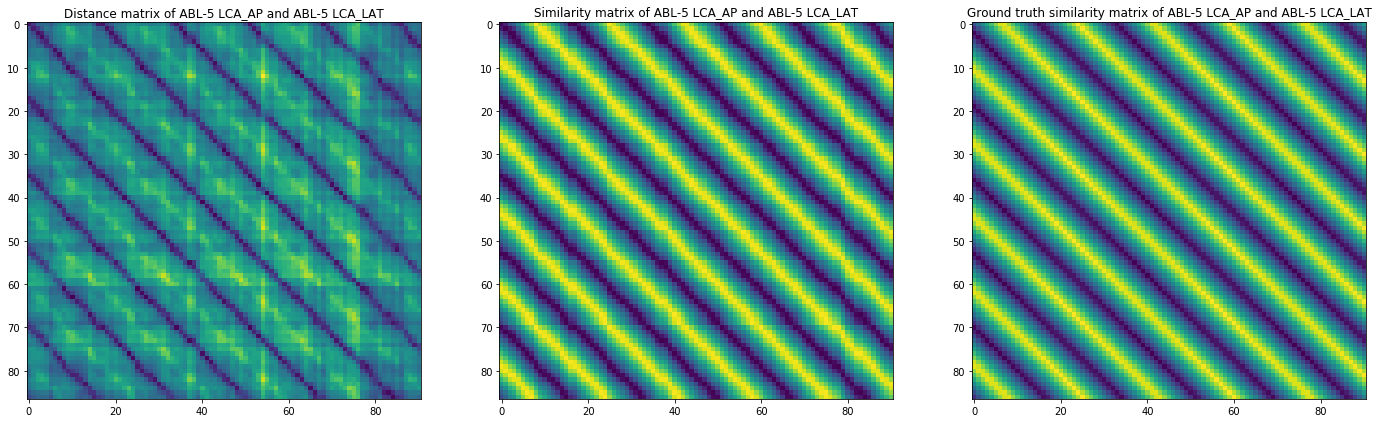

Mean score: 0.9070620214259065 for 473 scores


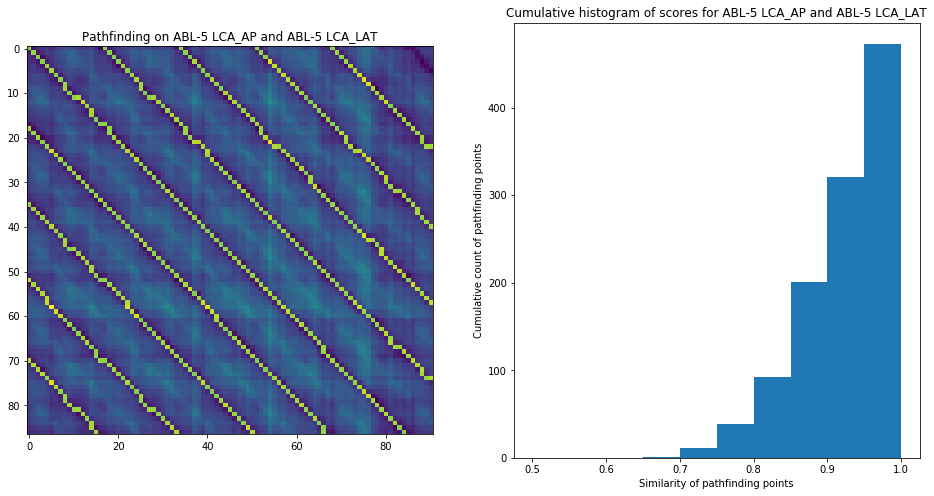

Mean score: 0.9083033630988931 for 479 scores


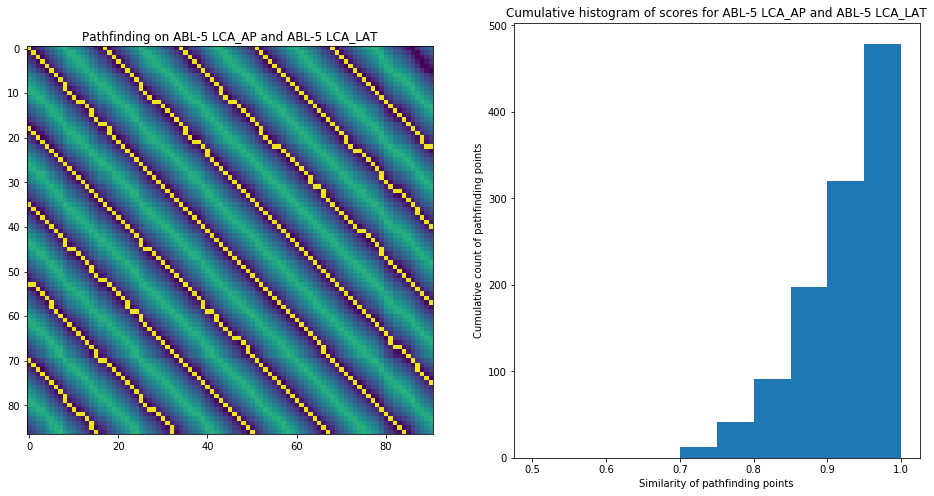

distance_matrix (87, 38)
ground_truth (87, 38)


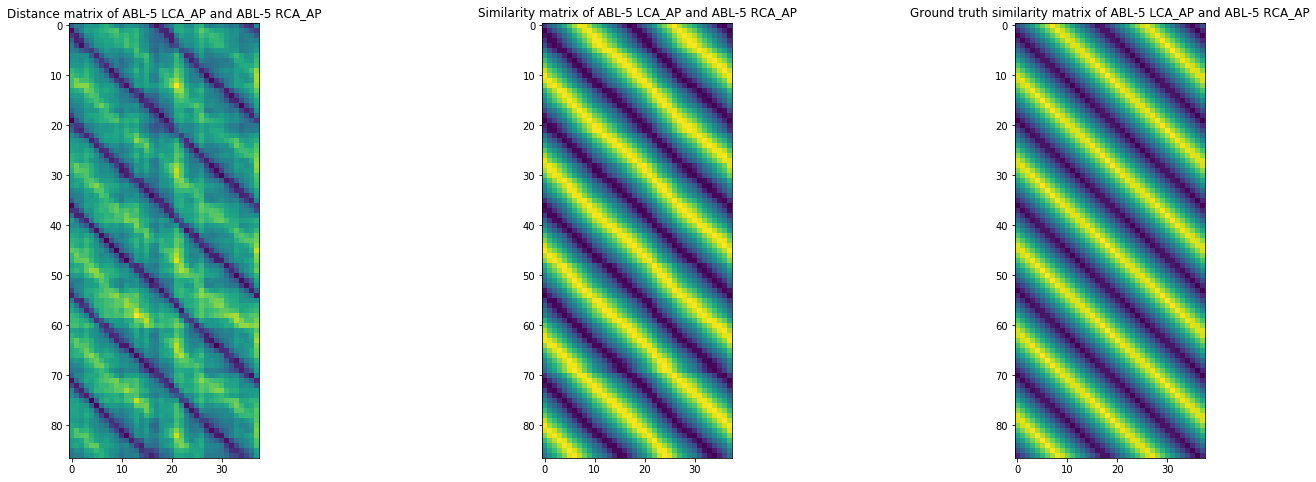

Mean score: 0.9049656665426378 for 188 scores


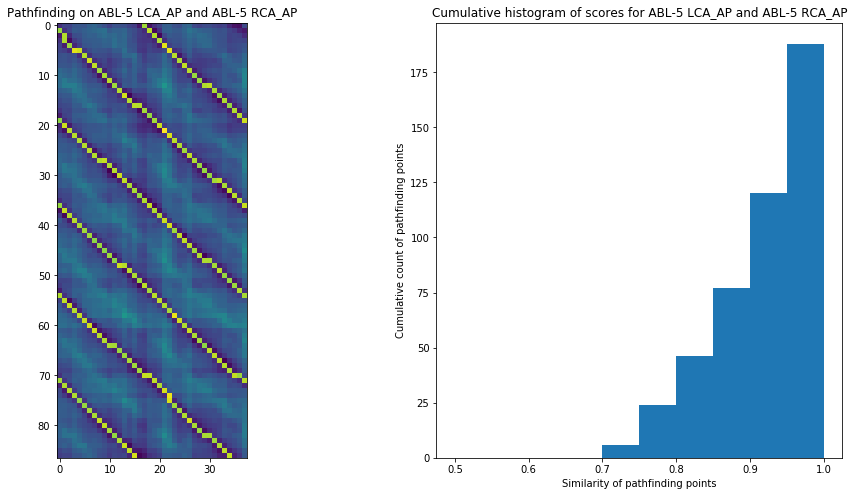

Mean score: 0.9023224905577848 for 189 scores


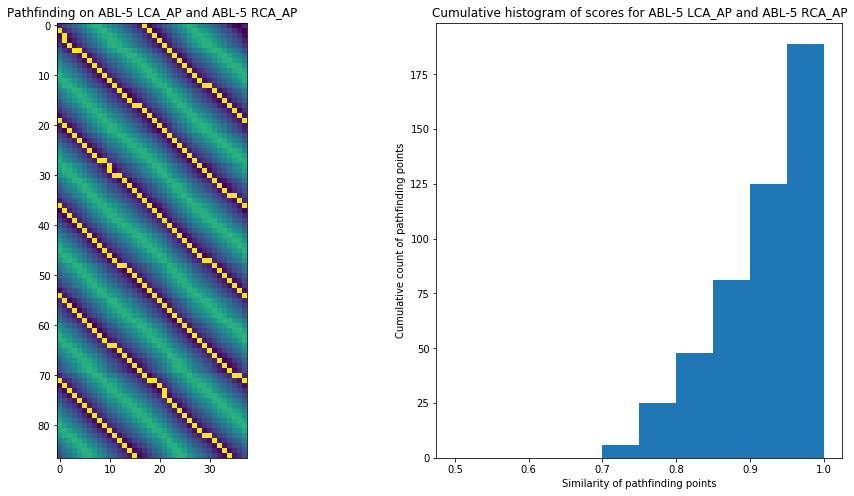

distance_matrix (87, 38)
ground_truth (87, 38)


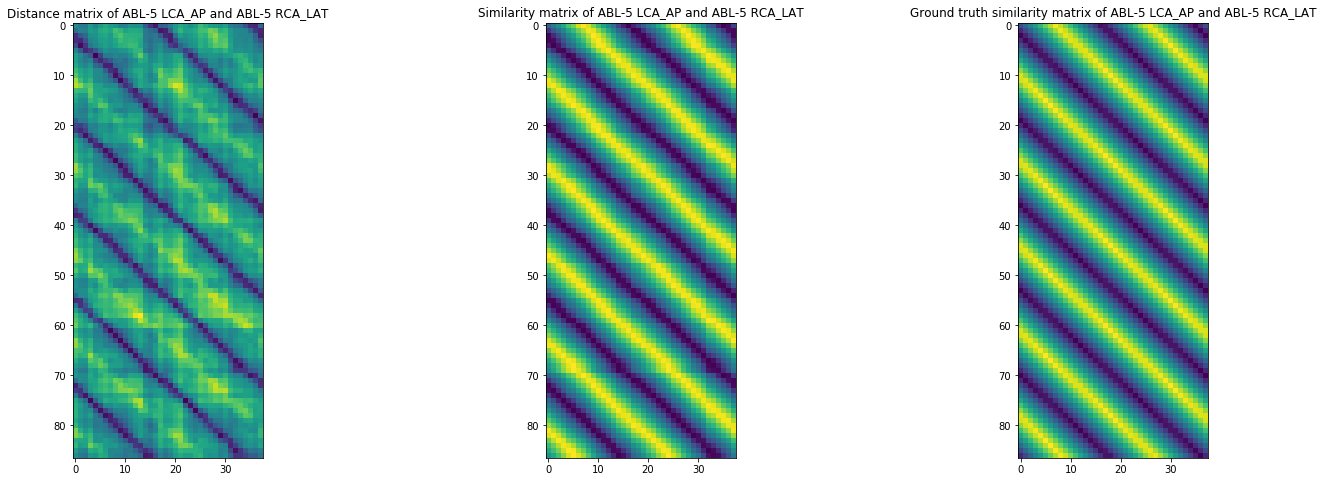

Mean score: 0.8519677274002536 for 187 scores


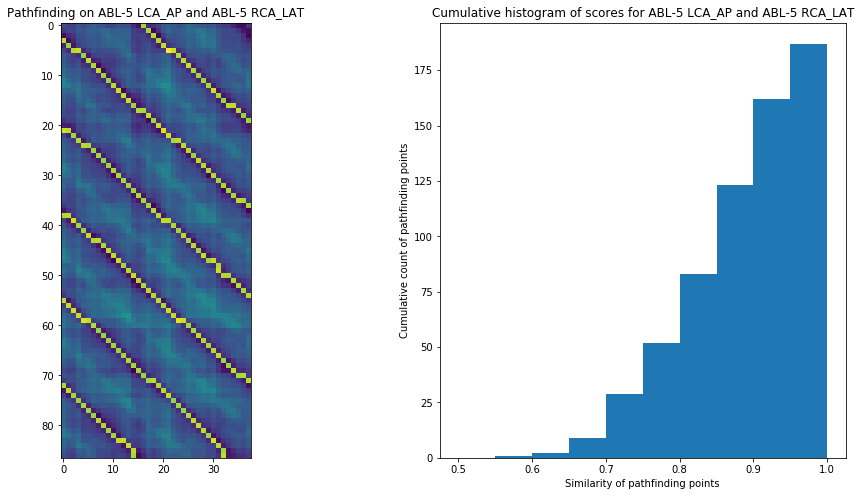

Mean score: 0.8515204816831851 for 188 scores


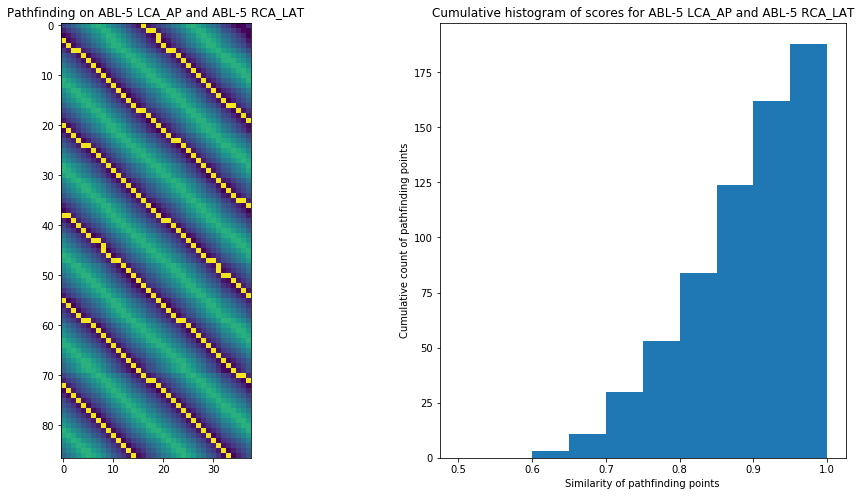

distance_matrix (91, 91)
ground_truth (91, 91)


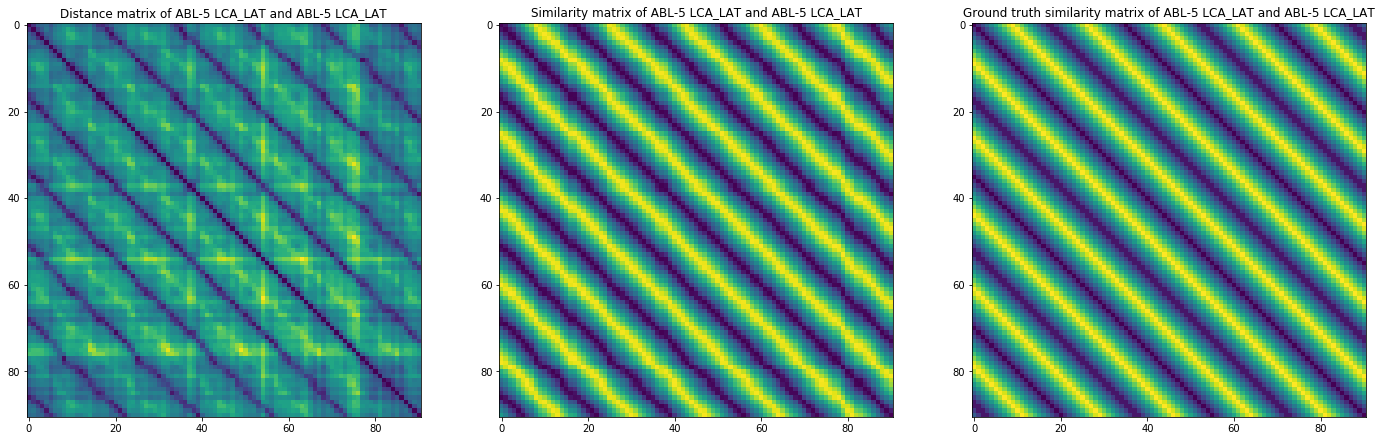

Mean score: 0.8980392156862745 for 408 scores


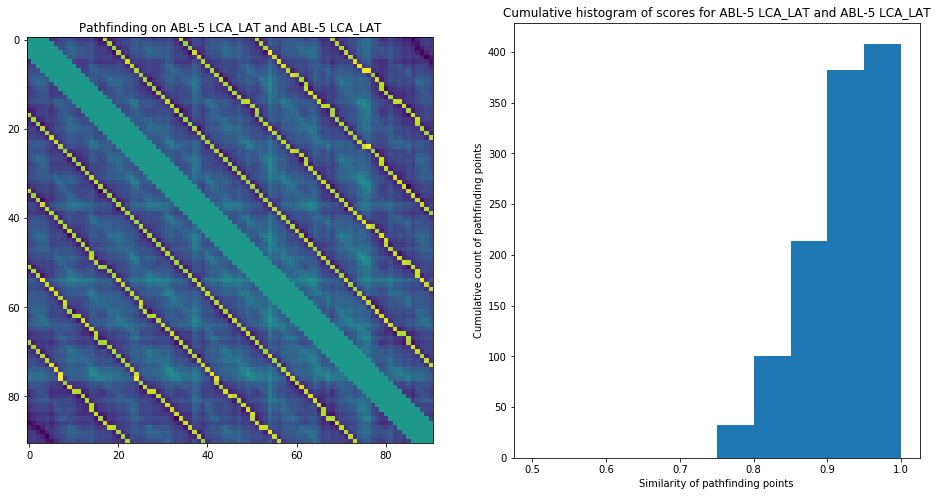

Mean score: 0.7614481409001957 for 584 scores


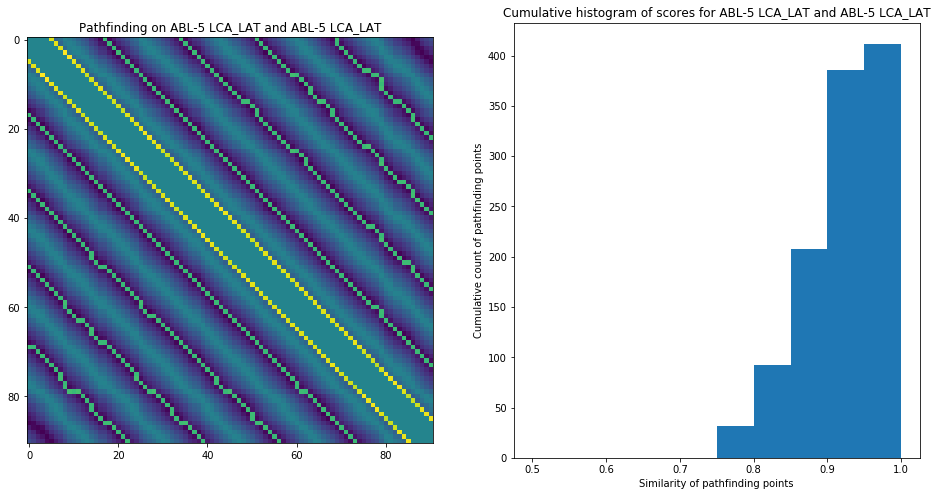

distance_matrix (91, 38)
ground_truth (91, 38)


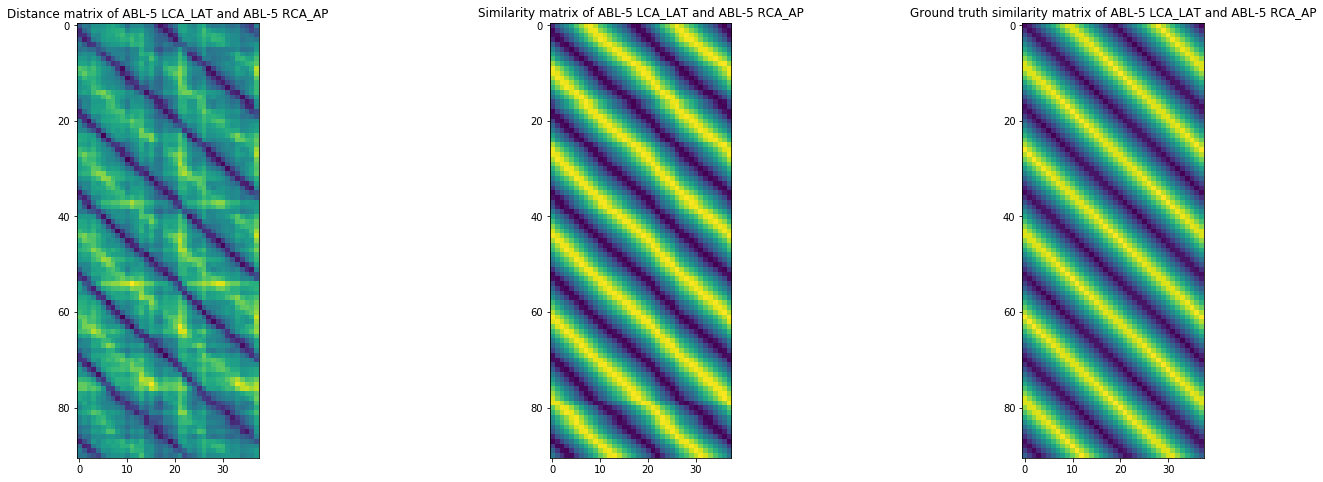

Mean score: 0.9177353951223297 for 199 scores


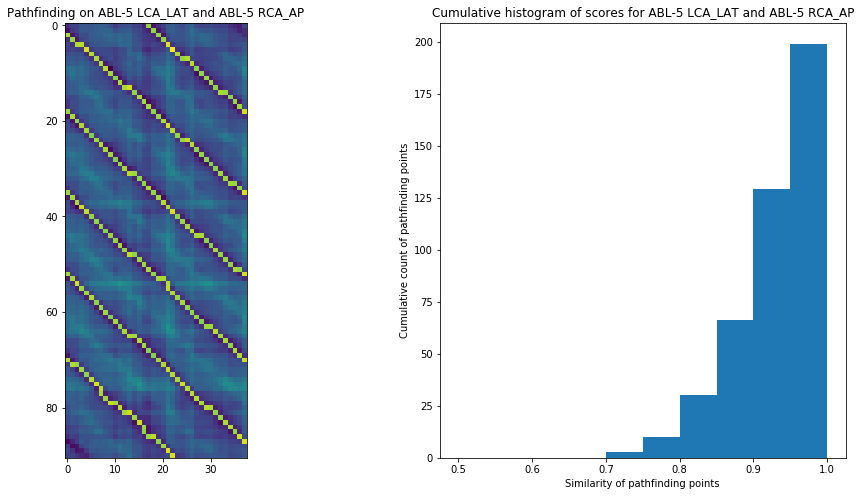

Mean score: 0.9194488606253313 for 204 scores


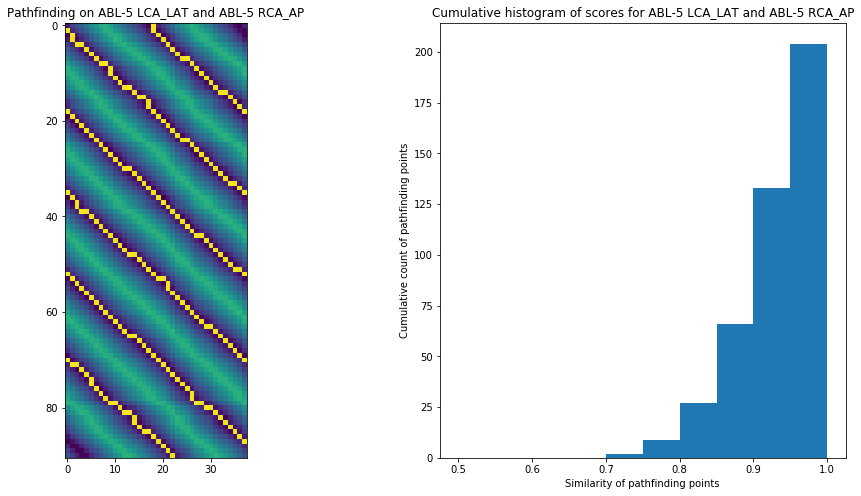

distance_matrix (91, 38)
ground_truth (91, 38)


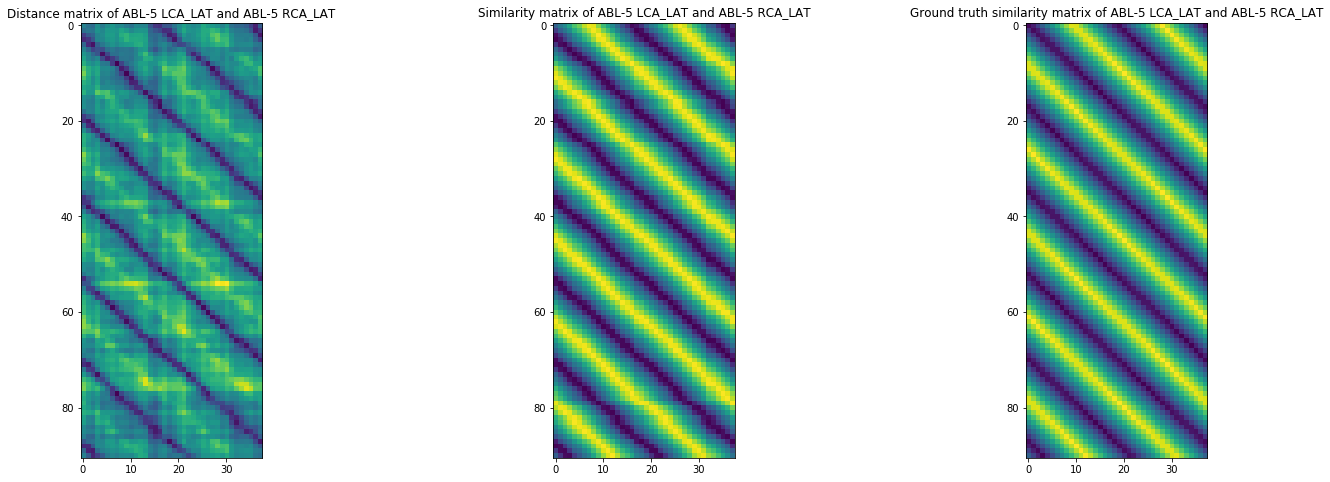

Mean score: 0.8766030926834948 for 199 scores


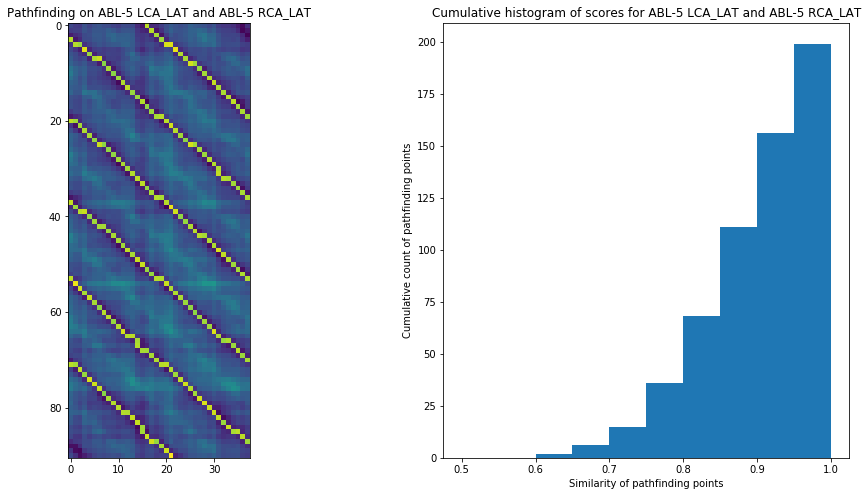

Mean score: 0.8743195220807161 for 201 scores


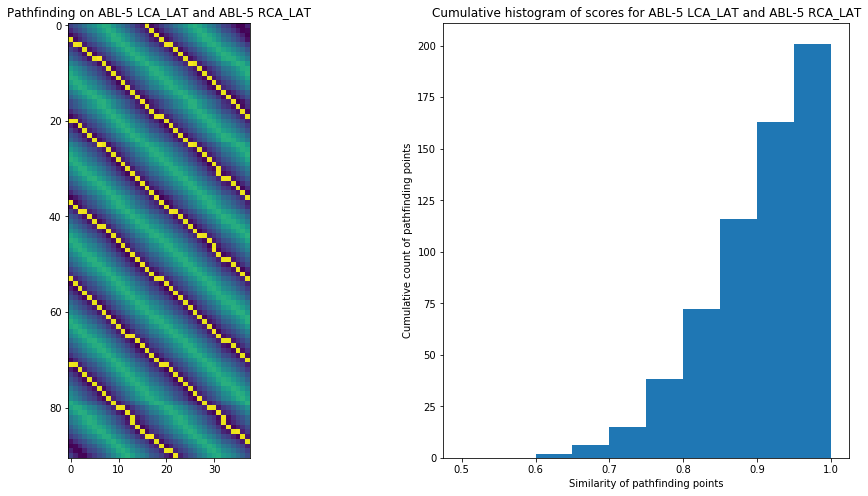

distance_matrix (38, 38)
ground_truth (38, 38)


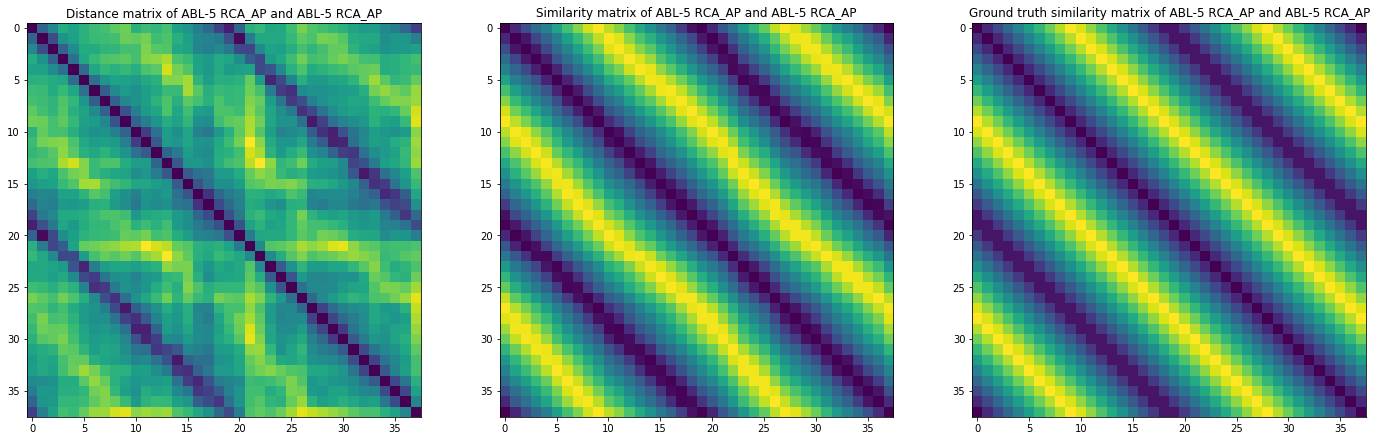

Mean score: 0.9459459459459459 for 40 scores


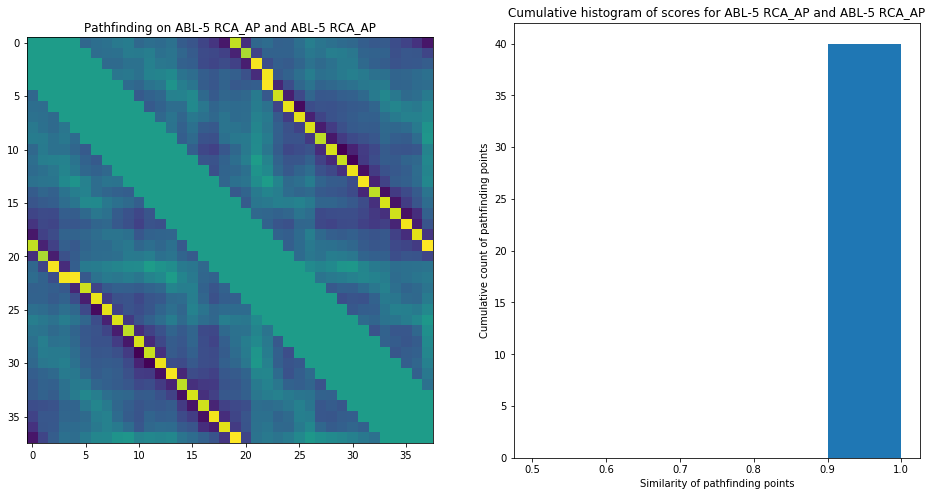

Mean score: 0.648648648648649 for 108 scores


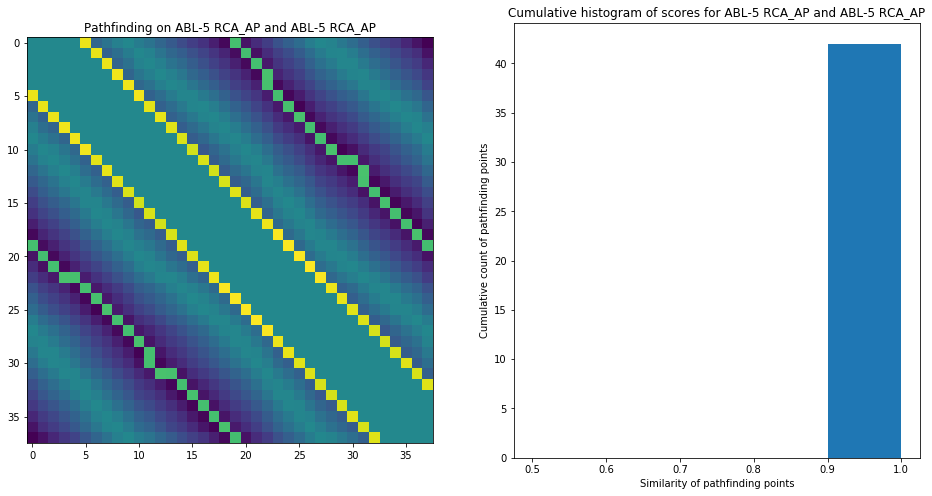

distance_matrix (38, 38)
ground_truth (38, 38)


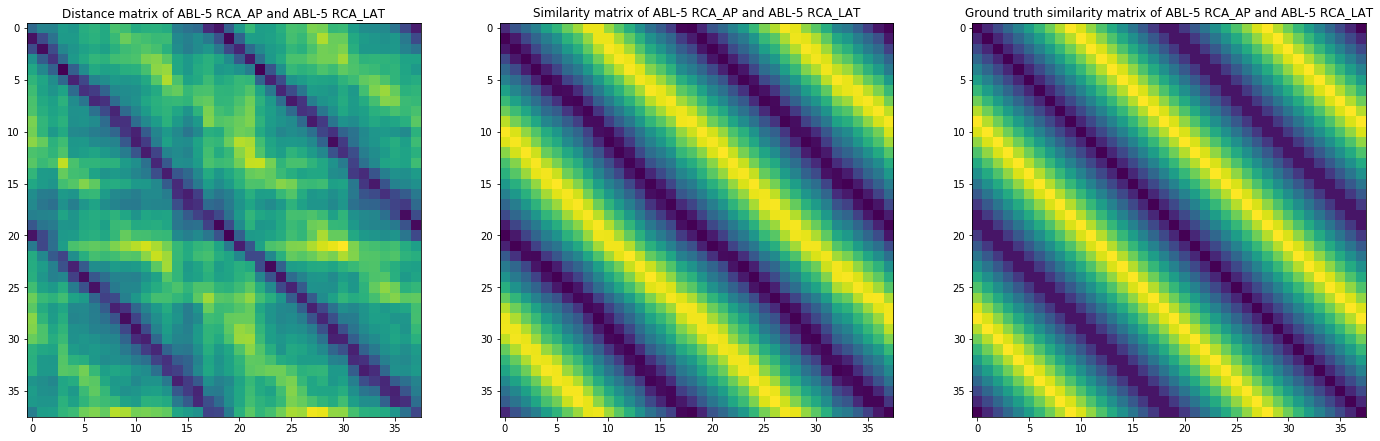

Mean score: 0.9355509355509357 for 78 scores


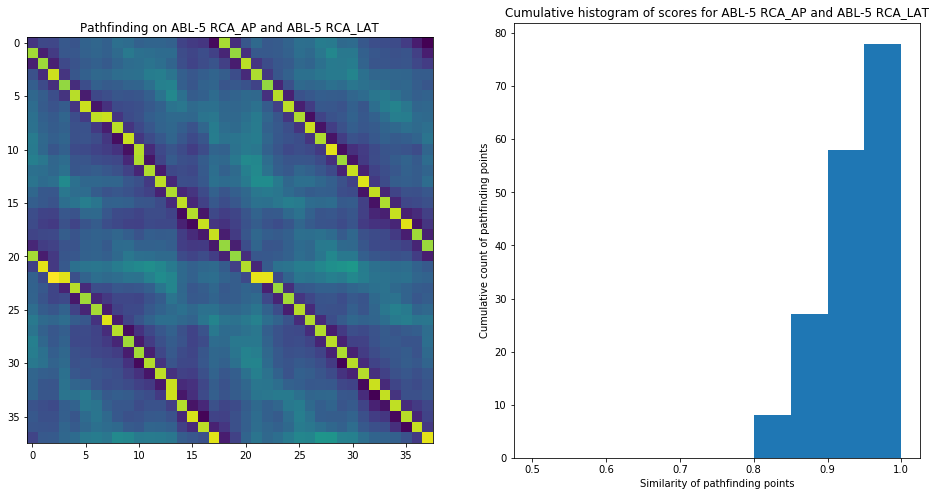

Mean score: 0.9336298323640096 for 79 scores


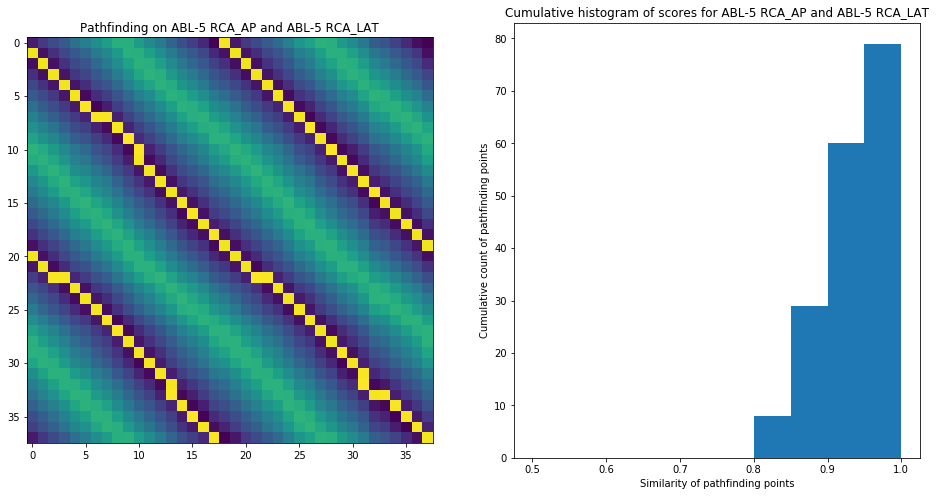

distance_matrix (38, 38)
ground_truth (38, 38)


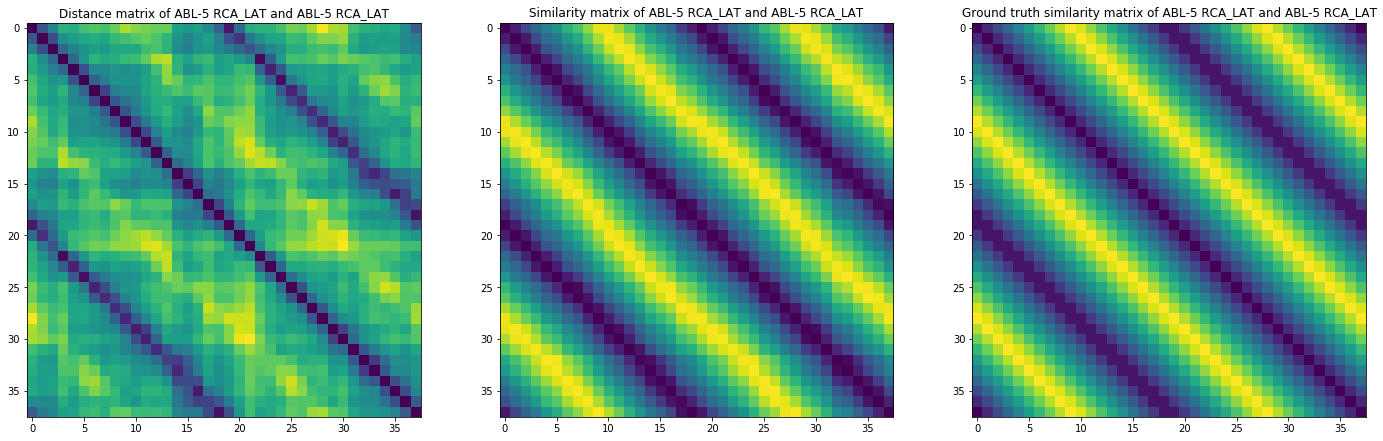

Mean score: 0.9459459459459459 for 38 scores


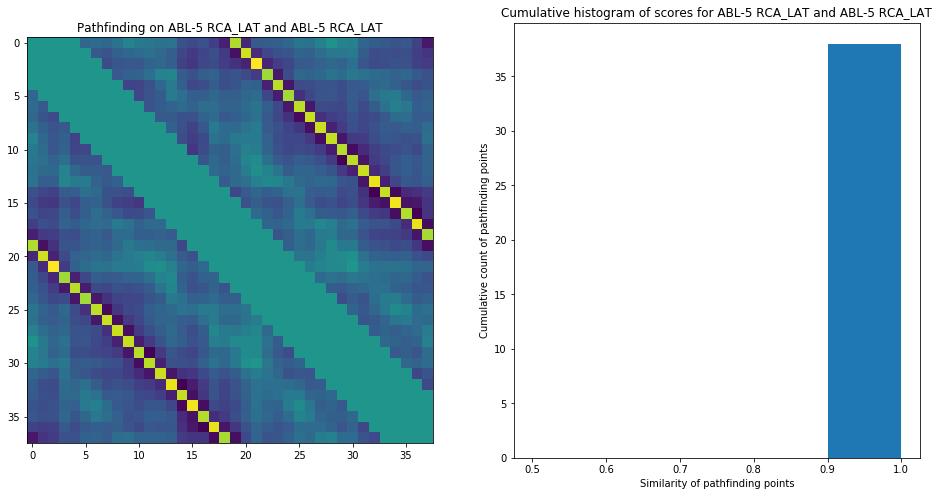

Mean score: 0.6372141372141372 for 104 scores


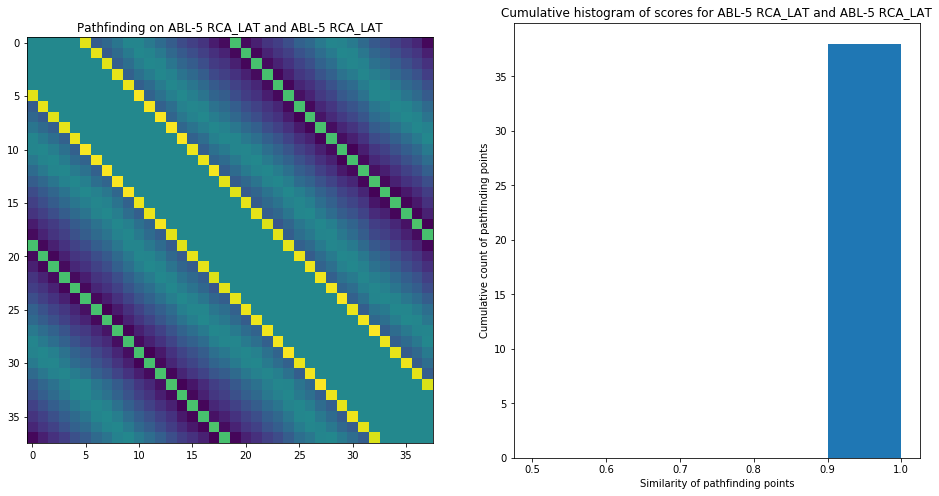

In [6]:
import utils
reload(utils)
from utils import pathfinding

save_pairs = False
good_angle_pairs = [
    # ("G1 18", "G1 20")
#     ("G18 10", "G18 18"),
#     ("G18 13", "G18 17"),
#     ("G18 13", "G18 18"),
#     ("G18 14", "G18 18"),
#     ("G18 15", "G18 18"),
#     ("G18 17", "G18 18"),
#     ("G18 18", "G18 18"),
#     ("G18 18", "G18 19"),
#     ("G18 18", "G18 9")
]

all_distance_scores = np.array([])
all_similarity_scores = np.array([])
ordered_distance_scores = []
all_paths = {}
for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    if len(good_angle_pairs) > 0:
        found = False
        for good_angle_pair in good_angle_pairs:
            if good_angle_pair[0] == name_a:
                found = True
                break
        if not found:
            continue
    sequences_a = sequences_a[0][0]
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        if len(good_angle_pairs) > 0 and (name_a, name_b) not in good_angle_pairs:
            continue
        if name_b in distance_matrices[name_a]:
            symmetrical = name_a == name_b
            distance_matrix = np.copy(distance_matrices[name_a][name_b])
            similarity_matrix = np.copy(similarity_matrices[name_a][name_b])
            ground_truth = test_set.get_similarity_matrix(name_a, name_b)
            print("distance_matrix", distance_matrix.shape)
            print("ground_truth", ground_truth.shape)
            figure(figsize=(24,8))
            plt.subplot(1, 3, 1)
            plt.imshow(distance_matrix)
            plt.title(f"Distance matrix of {name_a} and {name_b}")
            plt.subplot(1, 3, 2)
            plt.imshow(similarity_matrix)
            plt.title(f"Similarity matrix of {name_a} and {name_b}")
            plt.subplot(1, 3, 3)
            plt.imshow(1 - ground_truth)
            plt.title(f"Ground truth similarity matrix of {name_a} and {name_b}")
            plt.show()
            for matrix_type in range(2):
                matrix = distance_matrix if matrix_type == 0 else similarity_matrix
                line_value = matrix.max() * 1.5
                if symmetrical:
                    # Erase center line
                    for i in range(len(matrix)):
                        matrix[i, i] = matrix.max()
                        for j in range(4):
                            if i > j:
                                offset = j + 1
                                matrix[i-offset, i] = matrix.max()
                                matrix[i, i-offset] = matrix.max()
                nodes = pathfinding(matrix, symmetrical)
                scores = []
                if name_a not in all_paths:
                    all_paths[name_a] = {}
                if name_b not in all_paths[name_a]:
                    all_paths[name_a][name_b] = []
                for pathfinding_index, node in enumerate(nodes):
                    # print(node.point, node.cost)
                    pairs = []
                    current_scores = []
                    path_scores = []
                    while node is not None:
                        pairs.append(node.point)
                        node = node.parent
                    if len(pairs) < 10:
                        continue
                    for point in pairs:
                        current_scores.append(ground_truth[point])
                        path_scores.append((point, ground_truth[point]))
                        matrix[point] += line_value
                    scores += current_scores
                    if matrix_type == 0:
                        all_paths[name_a][name_b].append(path_scores)
                    if save_pairs:
                        matrix_type = "distance" if i == 0 else "similarity"
                        # print(matrix_type, pathfinding_index, current_scores)
                        mean_score = int(np.array(current_scores).mean() * 1000) / 1000
                        comparison_save_path = test_folder_path + f"\\comparisons\\{name_a}\\{name_b}\\pathfinding\\{matrix_type}_{pathfinding_index} ({len(pairs)}_{mean_score})"
                        if not os.path.isdir(comparison_save_path):
                            os.makedirs(comparison_save_path)
                        for pair_index, pair in enumerate(pairs):
                            plt.subplot(1, 2, 1)
                            plt.imshow(sequences_a[pair[0], -1])
                            plt.title(f"Frame {pair[0]}")
                            plt.subplot(1, 2, 2)
                            plt.imshow(sequences_b[pair[1], -1])
                            plt.title(f"Frame {pair[1]}")
                            plt.suptitle(f"{name_a} vs {name_b}")
                            plt.savefig(comparison_save_path + f"\\{pair_index}.png")
                            
                bins = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
                scores = np.array(scores)
                print("Mean score:", scores.mean(), f"for {len(scores)} scores")
                if matrix_type == 0:
                    all_distance_scores = np.append(all_distance_scores, scores)
                    ordered_distance_scores.append((scores.mean(), name_a + " - " + name_b))
                else:
                    all_similarity_scores = np.append(all_similarity_scores, scores)
                figure(figsize=(16,8))
                plt.subplot(1, 2, 1)
                plt.imshow(matrix)
                plt.title(f"Pathfinding on {name_a} and {name_b}")
                plt.subplot(1, 2, 2)
                plt.hist(scores, bins, histtype='stepfilled', cumulative=True)
                plt.title(f"Cumulative histogram of scores for {name_a} and {name_b}")
                plt.xlabel("Similarity of pathfinding points")
                plt.ylabel("Cumulative count of pathfinding points")
                plt.show()

ordered_distance_scores.sort(key=lambda x: x[0])

## Global pathfinding results

In [11]:
average_score = 0
count = 0
selected_paths = {}
for name_a, video_pairs in all_paths.items():
    selected_paths[name_a] = {}
    for name_b, paths in video_pairs.items():
        # Find longest path
        max_length = 0
        for path in paths:
            dist = np.sqrt((path[0][0][0] - path[-1][0][0]) ** 2 + (path[0][0][1] - path[-1][0][1]) ** 2)
            if dist > max_length:
                max_length = dist

        # Find the straightest long path
        max_straightness = 0
        straightest_path = -1
        for path_index, path in enumerate(paths):
            dist = np.sqrt((path[0][0][0] - path[-1][0][0]) ** 2 + (path[0][0][1] - path[-1][0][1]) ** 2)
            if dist >= max_length * 0.9:
                straightness = dist / (len(path) - 1) / np.sqrt(2)
                if straightness > max_straightness:
                    max_straightness = straightness
                    straightest_path = path_index

        selected_paths[name_a][name_b] = paths[straightest_path]
        
        # Find the max score path on the ground truth matrix
        ground_truth = test_set.get_similarity_matrix(name_a, name_b)
        symmetrical = name_a == name_b
        starting_point = paths[straightest_path][0][0]
        ground_truth_node = pathfinding(1-ground_truth, symmetrical, starting_points=[starting_point])[0]
        ground_truth_path = []
        while ground_truth_node is not None:
            ground_truth_path.append((ground_truth_node.point, ground_truth[ground_truth_node.point]))
            ground_truth_node = ground_truth_node.parent
        
        score = np.array([x[1] for x in paths[straightest_path]]).mean()
        max_score = np.array([x[1] for x in ground_truth_path]).mean()
        adjusted_score = score / max_score
        average_score += adjusted_score
        count += 1
        print(f"{name_a}, {name_b}: Path {straightest_path} of length {len(paths[straightest_path])} with straightness of {round(max_straightness * 1000) / 10}% and score of {round(score * 1000) / 1000}/{round(max_score * 1000) / 1000}={round(adjusted_score * 1000) / 1000}")
print("Average score", average_score / count)

ABL-5 LCA_30LAO25CRA, ABL-5 LCA_30LAO25CRA: Path 0 of length 58 with straightness of 96.5% and score of 0.937/0.946=0.99
ABL-5 LCA_30LAO25CRA, ABL-5 LCA_30RAO: Path 0 of length 74 with straightness of 96.6% and score of 0.93/0.972=0.957
ABL-5 LCA_30LAO25CRA, ABL-5 LCA_AP: Path 0 of length 76 with straightness of 95.4% and score of 0.876/0.971=0.903
ABL-5 LCA_30LAO25CRA, ABL-5 LCA_LAT: Path 0 of length 78 with straightness of 91.6% and score of 0.956/0.971=0.984
ABL-5 LCA_30LAO25CRA, ABL-5 RCA_AP: Path 2 of length 40 with straightness of 93.6% and score of 0.924/1.0=0.924
ABL-5 LCA_30LAO25CRA, ABL-5 RCA_LAT: Path 0 of length 38 with straightness of 97.3% and score of 0.792/0.946=0.838
ABL-5 LCA_30RAO, ABL-5 LCA_30RAO: Path 0 of length 62 with straightness of 99.2% and score of 0.996/1.0=0.996
ABL-5 LCA_30RAO, ABL-5 LCA_AP: Path 0 of length 84 with straightness of 93.4% and score of 0.938/0.972=0.965
ABL-5 LCA_30RAO, ABL-5 LCA_LAT: Path 0 of length 84 with straightness of 92.2% and score

### Score taking into account the length of the path (not necessarily better)

In [ ]:
selected_path_scores = []
for name_a, values in selected_paths.items():
    for name_b, path in values.items():
        selected_path_scores += [x[1] for x in path]
selected_path_scores = np.array(selected_path_scores)
print(selected_path_scores.mean())

### Graphs of path scores

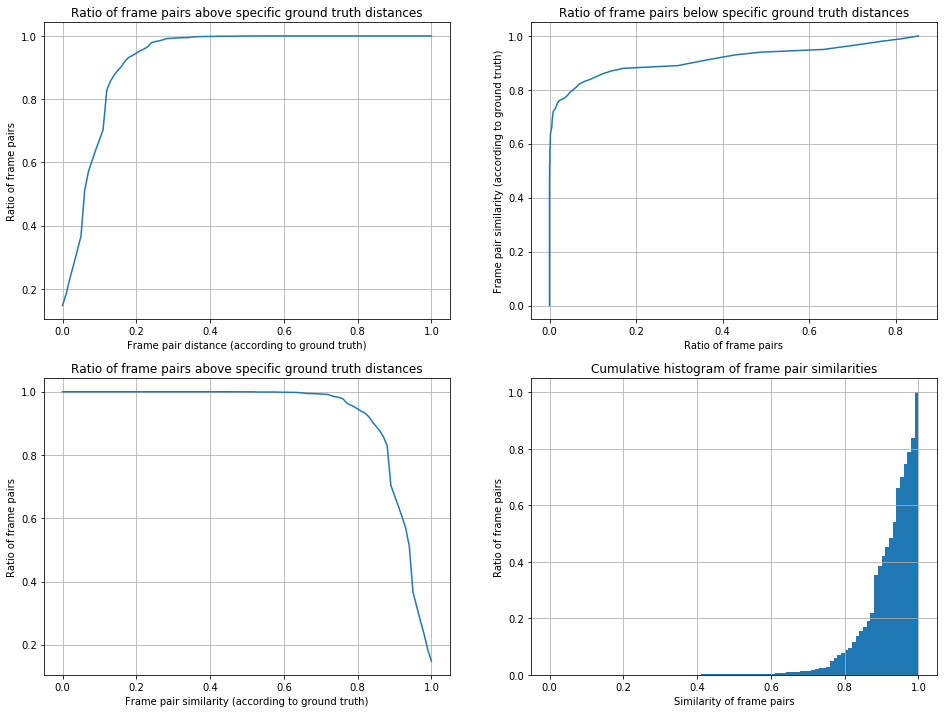

In [30]:
scores = []
for percentage in reversed(range(101)):
    # res = np.where(all_distance_scores >= percentage / 100)
    res = np.where(selected_path_scores >= percentage / 100)
    count = len(res[0])
    # score = count / len(all_distance_scores)
    score = count / len(selected_path_scores)
    scores.append(score)
scores = np.array(scores)

# print("Total distance score mean:", round(all_distance_scores.mean() * 10000) / 10000)
# print("Total distance score variance:", round(all_distance_scores.var() * 10000) / 10000)
# print("Total similarity score mean:", round(all_similarity_scores.mean() * 10000) / 10000)
# print("Total similarity score variance:", round(all_similarity_scores.var() * 10000) / 10000)
# print("Ordered distance scores:", ordered_distance_scores)

figure(figsize=(16,12))
plt.subplot(2, 2, 1)
plt.title("Ratio of frame pairs above specific ground truth distances")
plt.xlabel("Frame pair distance (according to ground truth)")
plt.ylabel("Ratio of frame pairs")
plt.plot(np.arange(101)/100, scores)
plt.grid(True)
# plt.show()

plt.subplot(2, 2, 2)
plt.title("Ratio of frame pairs below specific ground truth distances")
plt.xlabel("Ratio of frame pairs")
plt.ylabel("Frame pair similarity (according to ground truth)")
plt.plot(1-scores, 1-np.arange(101)/100)
plt.grid(True)
# plt.show()

plt.subplot(2, 2, 3)
plt.title("Ratio of frame pairs above specific ground truth distances")
plt.xlabel("Frame pair similarity (according to ground truth)")
plt.ylabel("Ratio of frame pairs")
plt.plot(1-np.arange(101)/100, scores)
plt.grid(True)
# plt.show()

plt.subplot(2, 2, 4)
plt.title(f"Cumulative histogram of frame pair similarities")
plt.xlabel("Similarity of frame pairs")
plt.ylabel("Ratio of frame pairs")
plt.hist(all_distance_scores, np.arange(101)/100, histtype='stepfilled', cumulative=True, density=True)
plt.grid(True)
plt.show()

## Generate frame pairs from paths

ABL-5 LCA_30LAO25CRA ABL-5 LCA_30LAO25CRA


c:\logiciels\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
c:\logiciels\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


ABL-5 LCA_30LAO25CRA ABL-5 LCA_30RAO
ABL-5 LCA_30LAO25CRA ABL-5 LCA_AP
ABL-5 LCA_30LAO25CRA ABL-5 LCA_LAT
ABL-5 LCA_30LAO25CRA ABL-5 RCA_AP
ABL-5 LCA_30LAO25CRA ABL-5 RCA_LAT
ABL-5 LCA_30RAO ABL-5 LCA_30RAO
ABL-5 LCA_30RAO ABL-5 LCA_AP
ABL-5 LCA_30RAO ABL-5 LCA_LAT
ABL-5 LCA_30RAO ABL-5 RCA_AP
ABL-5 LCA_30RAO ABL-5 RCA_LAT
ABL-5 LCA_AP ABL-5 LCA_AP
ABL-5 LCA_AP ABL-5 LCA_LAT
ABL-5 LCA_AP ABL-5 RCA_AP
ABL-5 LCA_AP ABL-5 RCA_LAT
ABL-5 LCA_LAT ABL-5 LCA_LAT
ABL-5 LCA_LAT ABL-5 RCA_AP
ABL-5 LCA_LAT ABL-5 RCA_LAT
ABL-5 RCA_AP ABL-5 RCA_AP
ABL-5 RCA_AP ABL-5 RCA_LAT
ABL-5 RCA_LAT ABL-5 RCA_LAT
G1 15 G1 15
G1 15 G1 16
G1 15 G1 17
G1 15 G1 18
G1 15 G1 19
G1 15 G1 20
G1 15 G1 21
G1 15 G1 22
G1 15 G1 23
G1 16 G1 16
G1 16 G1 17
G1 16 G1 18
G1 16 G1 19
G1 16 G1 20
G1 16 G1 21
G1 16 G1 22
G1 16 G1 23
G1 17 G1 17
G1 17 G1 18
G1 17 G1 19
G1 17 G1 20
G1 17 G1 21
G1 17 G1 22
G1 17 G1 23
G1 18 G1 18
G1 18 G1 19
G1 18 G1 20
G1 18 G1 21
G1 18 G1 22
G1 18 G1 23
G1 19 G1 19
G1 19 G1 20
G1 19 G1 21
G1 19 G1 

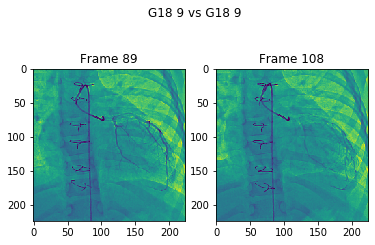

In [32]:
for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    sequences_a = sequences_a[0][0]
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        if name_a in selected_paths and name_b in selected_paths[name_a]:
            print(name_a, name_b)
            comparison_save_path = test_folder_path + f"\\comparisons\\{name_a}\\{name_b}\\pathfinding"
            if not os.path.isdir(comparison_save_path):
                os.makedirs(comparison_save_path)
            for pair_index, pair in enumerate([x[0] for x in selected_paths[name_a][name_b]]):
                plt.subplot(1, 2, 1)
                plt.imshow(sequences_a[pair[0], -1])
                plt.title(f"Frame {pair[0]}")
                plt.subplot(1, 2, 2)
                plt.imshow(sequences_b[pair[1], -1])
                plt.title(f"Frame {pair[1]}")
                plt.suptitle(f"{name_a} vs {name_b}")
                plt.savefig(comparison_save_path + f"\\{pair_index}.png")